# Notebook to process mass spectrometry data from the MassBank of North America (MoNA) database.

Data file is .sdf format, each chemical sample is a rdkit Chem.

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit import RDLogger

# suppress rdkit error messages
RDLogger.logger().setLevel(RDLogger.CRITICAL)
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from itertools import combinations

import statistics

import seaborn as sns

from collections import Counter

In [19]:
# # Original files containing all molecules
# file_path = '/home/cmdunham/ChemicalDataGeneration/data/MoNA_data/MoNA-export-Experimental_Spectra.sdf'
# Filtered files containing only mols with InCHIKey identifiers.
# file_path = '/home/cmdunham/ChemicalDataGeneration/data/ms1_ms2_with_inchikey.sdf'
# file_path = '/home/cmdunham/ChemicalDataGeneration/data/gc_ms_with_inchikey.sdf'


file_path = '../data/MoNA_data/MoNA-export-GC-MS_Spectra.sdf'
original_suppl = Chem.SDMolSupplier(file_path)

# Function Defs:
---


In [20]:
def plot_spectrum(spec, name):

    numbers = range(0,len(spec))

    plt.bar(numbers, spec)
    plt.title(f'{name} GC-MS Spectrum', fontsize=20)
    plt.xlabel('Mass to Charge Ratio', fontsize=16)
    plt.ylabel('Relative Intensity', fontsize=16)
    plt.show()

In [21]:
def get_weighted_cosine_similarity(output, target):
    # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
    mz = np.arange(1, len(target)+1)

    numerator = np.sum(mz * output * target)
    output_denom = np.sqrt(np.sum(mz * output**2))
    target_denom = np.sqrt(np.sum(mz * target**2))
    weighted_cosine_similarity = numerator / (output_denom * target_denom)
    return weighted_cosine_similarity

In [81]:
def plot_spectra_comparison(name, spec1, spec2, comparison_type, window=None):
    _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(22, 6))  
    if not window:
        window = max(len(spec1), len(spec2))

    # Pad the shorter spectrum with zeros
    if len(spec1) < window:
        spec1 += [0] * (window - len(spec1))
    elif len(spec2) < window:
        spec2 += [0] * (window - len(spec2))
    numbers = range(0,window)

    ax[0].bar(numbers, spec1[:window])
    ax[0].set_title(f'{comparison_type} for {name}', fontsize=24)
    ax[0].set_xlabel('Mass to Charge Ratio', fontsize=20)
    ax[0].set_ylabel('Intensity', fontsize=20)

    ax[1].bar(numbers, spec2[:window])
    ax[1].set_title(f'MSD between spectra: {round(MSE(spec1[:window], spec2[:window]),2)}', fontsize=24)
    ax[1].set_xlabel('Mass to Charge Ratio', fontsize=20)
    ax[1].set_ylabel('Intensity', fontsize=20)

    plt.show()

Currently rounding m/z ratios. This might not be the best approach. Might be more accurate to have m/z values every .1 steps rather than at every whole number. It seems to vary between samples on whether m/z values are whole numbers but we could probably still use the info from the labs that do include more detail. Another option would be to exclude the samples that use decimals, as it seems to be a small minority of the data.

In [23]:
def format_spectrum(chem, return_m_z_type=False):
    """
    Format the mass spectrum data from an RDKit chemical.

    This function extracts mass spectral peaks from the given chemical sample,
    separates the m/z ratios from their corresponding intensities, and scales the 
    intensities if the base peak is not 100. It returns a list of intensities 
    corresponding to each m/z ratio, and can also return the type of m/z values 
    (either 'int' or 'float').

    Parameters:
    - chem: A chemical object from which to extract mass spectral peaks.
    - return_m_z_type (bool): If True, the function will return a tuple with 
      the intensities list and the type of m/z values. If False, it will only 
      return the intensities list.

    Returns:
    - If return_m_z_type is False: A list of intensities corresponding to 
      m/z ratios (intensity_by_m_z).
    - If return_m_z_type is True: A tuple (intensity_by_m_z, m_z_type)
      where intensity_by_m_z is a list of intensities corresponding to 
      m/z ratios and m_z_type indicates the type of m/z values ('int' or 
      'float').
    """
    
    # Retrieve the "MASS SPECTRAL PEAKS" property from the provided chemical object
    spectrum = chem.GetProp("MASS SPECTRAL PEAKS")
    
    # the m/z ratios are currently at even indices in 'spectrum' and their
    # frequencies are at odd. Dividing into two lists
    spectrum = spectrum.split(' ')
    spectrum = [item.split('\n') for item in spectrum]
    spectrum = [i for item in spectrum for i in item]
    m_z_ratios = []
    intensities = []
    
    # Variable to determine the type of m/z values ('int' or 'float')
    m_z_type = 'int'
    
    # Iterate through the spectrum list, separating m/z ratios and frequencies
    for i, num in enumerate(spectrum):
        if i % 2 == 0:  # m/z ratios are at even indices
            # Check if m_z_type should be changed to 'float'
            if m_z_type == 'int':
                try:
                    _, after_decimal = num.split('.')
                    # If decimal is nonzero, classify sample as 'float'
                    if float(after_decimal) > 0:
                        m_z_type = 'float'
                # Handle cases where num does not contain a decimal point
                except ValueError as e:
                    if str(e) == "not enough values to unpack (expected 2, got 1)":
                        pass

            # Convert the m/z ratio to an integer and append to m_z_ratios
            m_z_ratios.append(int(float(num)))
        else:  # intensities are at odd indices
            # Convert the intensity to a float and append to frequencies
            intensities.append(float(num))

    # Scale intensities if the base peak is not 100
    base_peak = max(intensities)
    if base_peak != 100:
        intensities = [intensity/base_peak * 100 for intensity in intensities]

    # Create a list to hold intensity at each m/z ratio, initialized to 0
    max_length = max(m_z_ratios)
    intensity_by_m_z = [0] * max_length

    # Populate intensity_by_m_z with corresponding intensity
    for i, m_z in enumerate(m_z_ratios):
        # Assign the intensity to the correct m/z index
        intensity_by_m_z[m_z-1] = intensities[i]

    # Return either the intensity list with m/z type or just the intensity list
    if return_m_z_type:
        return intensity_by_m_z, m_z_type
    else:
        return intensity_by_m_z

In [24]:
# def format_spectrum(chem):
#     spectrum = chem.GetProp("MASS SPECTRAL PEAKS")
    
#     # Parsing spectrum 
#     spectrum = spectrum.split(' ')
#     spectrum = [item.split('\n') for item in spectrum]
#     spectrum = [i for item in spectrum for i in item]
#     m_z_ratios = []
#     intensities = []
    
#     # m/z ratios are currently at even indices in 'spectrum' and their
#     # frequencies are at odd. Dividing into two lists
#     for i, num in enumerate(spectrum):
#         if i % 2 == 0:
#             m_z_ratios.append(int(float(num)))
#         else: 
#             intensities.append(float(num))

#     # Scale intensities if the base peak is not 100
#     base_peak = max(intensities)
#     if base_peak != 100:
#         intensities = [intensity/base_peak * 100 for intensity in intensities]

#     # Create a list to hold intensity at each m/z ratio, initialized to 0
#     max_length = max(m_z_ratios)
#     intensity_by_m_z = [0] * max_length

#     # Populate intensity_by_m_z with corresponding intensity
#     for i, m_z in enumerate(m_z_ratios):
#         intensity_by_m_z[m_z-1] = intensities[i]

#     return intensity_by_m_z

In [25]:
# for i, mol in enumerate(suppl):
#     if i == 2:
#         spec = format_spectrum(mol)
#         print(spec)
#         print('-----------------------')
#         print(mol.GetProp("MASS SPECTRAL PEAKS"))
#         break

In [26]:
# len(spec[:31])

In [27]:
def get_smiles(mol):
    comment = mol.GetProp('COMMENT').split('\n')
    smiles = None
    for line in comment:
        if line.split('=')[0] == 'SMILES':
            smiles = line.split('SMILES=')[1]
    return smiles

In [28]:
def get_comparison_spectra(suppl, property, comparison_type, start_point=0, print_mol=False):
    """
    Retrieves the mass spectra for two molecules from the provided molecule supplier (suppl)
    based on the specified property and comparison type.

    Args:
        suppl (Chem.SDMolSupplier): RDKit molecule supplier.
        property (str): The name of the property to use for the comparison.
        comparison_type (str): The type of comparison to perform, either 'same' (two samples of the same chemical with the same experimental condition) 
            or 'different' (two samples of the same chemical with different experimental conditions).
        start_point (int, optional): The index to start the search from. Defaults to 0. The sample at index start_point is used as the first spectrum in the comparison.
            If a fitting comparison spectrum is not found, start_point will increment by 10. Incrementing by 10 was done as there are often many samples in a row 
            for the same chemical/same conditions.

    Returns:
        tuple: A tuple containing the formatted mass spectra for the two molecules and the instance of the property for each spec.
    """
    spectrum_2 = None
    for i, mol in enumerate(suppl):
        # Skip molecules before the start_point
        if i < start_point:
            pass
        # Process the first molecule at the start_point and record its inchikey and the instance of the specified property
        elif i == start_point:
            name = mol.GetProp('NAME')
            inchikey = mol.GetProp('INCHIKEY')
            prop = mol.GetProp(property)
            spectrum_1 = format_spectrum(mol)
            if print_mol:
                all_props = mol.GetPropNames()
                for prop_name in all_props:
                    if not prop_name == 'MASS SPECTRAL PEAKS':
                        print(prop_name, ':', mol.GetProp(prop_name))
                print('---------------------------------------------')
            # print(mol.GetProp('NAME'))
            # print(inchikey)
            i += 1
        # Process the remaining molecules
        else:
            if comparison_type == 'same':
                # If the INCHIKEY and the property match, use the sample for comparison
                if mol.GetProp('INCHIKEY') == inchikey and mol.GetProp(property) == prop:
                    prop2 = prop
                    spectrum_2 = format_spectrum(mol)
                    if print_mol:
                        all_props = mol.GetPropNames()
                        print(all_props)
                        for prop_name in all_props:
                            if not prop_name == 'MASS SPECTRAL PEAKS':
                                print(prop_name, ':', mol.GetProp(prop_name))
                        print('---------------------------------------------')
                    # print(mol.GetProp('NAME'))
                    # print(mol.GetProp('INCHIKEY'))
                    break
            elif comparison_type == 'different':
                # If the INCHIKEY matches but the property is different, use the sample for comparison
                if mol.GetProp('INCHIKEY') == inchikey and mol.GetProp(property) != prop:
                    prop2 = mol.GetProp(property)
                    spectrum_2 = format_spectrum(mol)
                    if print_mol:
                        all_props = mol.GetPropNames()
                        for prop_name in all_props:
                            if not prop_name == 'MASS SPECTRAL PEAKS':
                                print(prop_name, ':', mol.GetProp(prop_name))
                        print('---------------------------------------------')
                    # print(mol.GetProp('NAME'))
                    break

    # If no matching sample was found, recursively call the function with a higher start_point
    if not spectrum_2:
        spectrum_1, spectrum_2, prop, prop2, name  = get_comparison_spectra(suppl, property, comparison_type, start_point+10, print_mol=print_mol)

    return spectrum_1, spectrum_2, prop, prop2, name

In [29]:
def make_SDMOLSupplier_with_specified_properties(suppl, specified_props, mona_rating=False, file_path=False, inchikey_list=False):
    """
    Create a new SDMolSupplier containing only the molecules containing all the specified properties.

    Args:
        suppl (Chem.SDMolSupplier): The SDMolSupplier containing the molecules.
        specified_props (list): A list of property names to check for in the molecules.

    Returns:
        Chem.SDMolSupplier: A new SDMolSupplier containing only the molecules with the specified properties.
        total_samples (int): Count of all samples in the supplier.
        usable_samples (int): Count of all non-None samples in the supplier.
        usable_samples_w_specified_properties (int): Count of all non-None samples in the supplier which have the specified properties.
    """
    new_suppl = []  
    total_samples = 0
    usable_samples = 0
    usable_samples_w_specified_properties = 0

    for mol in suppl:
        total_samples += 1
        # Check if the molecule is not None and has all the specified properties
        if mol is not None:
            if inchikey_list:
                if mol.HasProp("INCHIKEY"):
                    if mol.GetProp("INCHIKEY") not in inchikey_list:
                        continue
            usable_samples +=1
            if all(mol.HasProp(prop) for prop in specified_props):
                # if MoNA rating is specified, only use mols with rating above limit
                if mona_rating:
                    comment = mol.GetProp('COMMENT').split('\n')
                    rating = None
                    for line in comment:
                        if line.split('=')[0] == 'MoNA Rating':
                            rating = line.split('=')[1]
                    if float(rating) > mona_rating:
                        pass
                    else:
                        continue
                new_suppl.append(mol)  # Add the molecule to the new supplier if it meets the criteria
                usable_samples_w_specified_properties += 1
                # else:
                #     new_suppl.append(mol)  # Add the molecule to the new supplier if it meets the criteria
                #     usable_samples_w_specified_properties += 1

    # !! This next step is necessary because SDMolSupplier takes a file path to make a new supplier object. !!
    # Create a temporary file path to write the filtered molecules to
    if not file_path:
        file_path  = '../data/MoNA_data/temp_sdf.sdf'
    # Open an SDWriter to write the filtered molecules to a temporary file. 
    with Chem.SDWriter(file_path) as writer:
        for mol in new_suppl:
            writer.write(mol) 
    
    # Create a new SDMolSupplier from the temporary file and return it
    return Chem.SDMolSupplier(file_path), total_samples, usable_samples, usable_samples_w_specified_properties


In [30]:
def make_property_count_dict(suppl, prop):
    """
    Create a dictionary that counts the occurrences of each unique value for a specified property
    across the molecules in the input supplier.

    Args:
        suppl (Chem.SDMolSupplier): The input supplier containing the molecules.
        prop (str): The name of the property to count.

    Returns:
        prop_count_dict (dict): A dictionary where keys are unique property values and values are
        counts of how many times each value appears.
     """
    
    prop_count_dict = {}
    for mol in suppl:
        if mol is not None: 
            # try:
            # Get the value of the specified property for the current molecule
            if prop == 'SMILES':
                prop_instance = get_smiles(mol)
            else:
                prop_instance = mol.GetProp(prop)

            # If the property value is already in the dictionary, increment its count by 1
            if prop_instance in prop_count_dict.keys():
                prop_count_dict[prop_instance] += 1
            # If the property value is not yet in the dictionary, add it with a count of 1
            else:
                prop_count_dict[prop_instance] = 1
            # except:
            #     # If the molecule does not have the specified property skip
            #     pass

    return prop_count_dict

# Dataset Overview:
---

In [31]:
# creating a list of all of all the properties we can access in the metadata
all_prop_names = set()
for chem in original_suppl:
    if chem is not None:
        prop_names = chem.GetPropNames()
        all_prop_names.update(prop_names)

all_prop_names = list(all_prop_names)

# print out prop names n/row just for display purposes
n=4
for i in range(0, len(all_prop_names), n):
    print(all_prop_names[i:i + n])

['NUM PEAKS', 'CONTRIBUTOR', 'INSTRUMENT TYPE', 'MW']
['ID', 'PRECURSOR M/Z', 'FORMULA', 'COMMENT']
['COLLISION ENERGY', 'MASS SPECTRAL PEAKS', 'NAME', 'PRECURSOR TYPE']
['EXACT MASS', 'INSTRUMENT', 'SYNONYMS', 'INCHIKEY']
['ION MODE', 'SPECTRUM TYPE']


In [32]:
# creating a list of all of all the properties that are common to all samples
first_iteration = True

for chem in original_suppl:
    if chem is not None:
        prop_names = chem.GetPropNames()
        if first_iteration:
            all_common_prop_names = prop_names
            first_iteration = False
        else:
            common_props = [prop for prop in all_common_prop_names if prop in prop_names]
            all_common_prop_names = common_props

# print out prop names n/row just for display purposes
n=4
for i in range(0, len(common_props), n):
    print(common_props[i:i + n])

['NAME', 'SYNONYMS', 'FORMULA', 'EXACT MASS']
['MW', 'ID', 'CONTRIBUTOR', 'COMMENT']
['NUM PEAKS', 'MASS SPECTRAL PEAKS']


I noticed that many of the spectra in the dataset have integer mass to charge ratios. This doesn't seem to be standard for mass spectrometry. Looking at what percentage of the entire dataset has integer m/z ratios.

In [33]:
# making list of all spectra in the dataset and counting how many have integer m/z ratios.
all_spectra_list = []
total_mols = 0
samples_w_int_m_z_values = 0

for mol in original_suppl:
    total_mols += 1
    if mol is not None:
        spec, m_z_type = format_spectrum(mol, return_m_z_type=True)
        all_spectra_list.append(spec)

        if m_z_type == 'int':
            samples_w_int_m_z_values +=1

all_spectra_df = pd.DataFrame(all_spectra_list)
all_spectra_df = all_spectra_df.fillna(0)

print(f'Of the {total_mols:,} total samples in the database, {round(samples_w_int_m_z_values/total_mols*100, 2)}% have integer m/z values.')

Of the 18,914 total samples in the database, 94.33% have integer m/z values.


In [34]:
smiles_count = 0
for mol in original_suppl:
    if mol is not None:
        smiles = get_smiles(mol)
        if smiles:
            smiles_count += 1

print(f'Of the {total_mols:,} total samples in the database, {smiles_count:,}, or {round(smiles_count/total_mols*100, 2)}%, have SMILES strings.')

Of the 18,914 total samples in the database, 17,551, or 92.79%, have SMILES strings.


Some of the samples in the database contain no information. Determining how many of the total samples are usable (contain information), and how many of the usable samples contain InCHIKey identifiers (more information: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4486400/):

For inchikey_count_dict: Counting number of samples for each chemical (as defined by InCHIKey).
For instrument_count_dict: Counting number of spectra generated using each instrument. Only including in this count the spectra that have a listed instrument type.

- [ ] Currently we have MS1 and MS2 spectra in the dataset. Determine how important that is/if both types should be included.

## Sorting by Inchikey:
---

In [35]:
# Only looking at mols with a listed inchikey and spectrum type
save_file_path = '../data/gc_ms_with_inchikey.sdf'
suppl, total_samples, usable_samples, usable_samples_w_inchikey = make_SDMOLSupplier_with_specified_properties(original_suppl, ['INCHIKEY', 'INSTRUMENT TYPE', 'SPECTRUM TYPE'], file_path=save_file_path)
print(f'Of the {total_samples:,} total samples in the database, {len(suppl):,}, or {round(len(suppl)/total_samples*100, 2)}%, have the specified properties.')

Of the 18,914 total samples in the database, 14,210, or 75.13%, have the specified properties.


In [36]:
inchikey_count_dict = make_property_count_dict(suppl, 'INCHIKEY')

threshold = 5

total_usable_spectra = 0
num_chems = 0

inchikeys_for_chems_past_threshold = []

for chem in inchikey_count_dict:
    if inchikey_count_dict[chem] >= threshold:
        total_usable_spectra += inchikey_count_dict[chem]
        num_chems += 1
        inchikeys_for_chems_past_threshold.append(chem)

print(f'There are {num_chems:,} chemicals, out of the total {len(inchikey_count_dict):,}, with more than the minimum threshold of {threshold} samples in the database. \nBetween these {num_chems:,} chemicals there are a total of {total_usable_spectra:,} spectra.')

There are 328 chemicals, out of the total 9,498, with more than the minimum threshold of 5 samples in the database. 
Between these 328 chemicals there are a total of 2,032 spectra.


In [37]:
# Only looking at mols with a listed inchikey and spectrum type !!!FROM THE LIST OF chems past the min spectrum threshold!!!!
save_file_path = '../data/gc_ms_with_inchikey.sdf'
suppl, total_samples, usable_samples, usable_samples_w_inchikey = make_SDMOLSupplier_with_specified_properties(original_suppl, ['INCHIKEY', 'INSTRUMENT TYPE', 'SPECTRUM TYPE'], file_path=save_file_path, inchikey_list=inchikeys_for_chems_past_threshold)
print(f'Of the {total_samples:,} total samples in the database, {len(suppl):,}, or {round(len(suppl)/total_samples*100, 2)}%, have the specified properties.')

Of the 18,914 total samples in the database, 2,032, or 10.74%, have the specified properties.


### Looking at conditions in the filtered dataset:
---

In [38]:
instrumental_configurations = []
instruments = []
for mol in suppl:
    props = mol.GetPropNames()
    for prop in props:
        # if not prop == 'MASS SPECTRAL PEAKS':
        #     print(prop, ':', mol.GetProp(prop))
        if prop == 'INSTRUMENT TYPE':
            instrumental_configurations.append(mol.GetProp(prop))
        if prop == 'INSTRUMENT':
            instruments.append(mol.GetProp(prop))
    # break

In [39]:
instrumental_configurations = []
for mol in suppl:
    instrumental_configurations.append(mol.GetProp("INSTRUMENT TYPE"))

In [40]:
n=4
print('Unique values for "INSTRUMENT TYPE":')
for i in range(0, len(instrumental_configurations), n):
    print(instrumental_configurations[i:i + n])

Unique values for "INSTRUMENT TYPE":
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF', 'GC-EI-TOF']
['GC-EI-T

In [41]:
instrumental_configurations_encoder = OneHotEncoder(sparse_output=False)
instrumental_configurations_reshaped = [[instrumental_configuration] for 
    instrumental_configuration in instrumental_configurations]

instrumental_configurations_encoded = instrumental_configurations_encoder.fit_transform(
    instrumental_configurations_reshaped)

instrumental_configurations_encoded

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [42]:
instrumental_configurations_encoded.shape

(2032, 7)

In [43]:
print(len(set(instrumental_configurations)), len(set(instruments)))

7 58


In [44]:
unique_instrumental_configurations = list(set(instrumental_configurations))
n=4
print('Unique values for "INSTRUMENT TYPE":')
for i in range(0, len(unique_instrumental_configurations), n):
    print(unique_instrumental_configurations[i:i + n])

Unique values for "INSTRUMENT TYPE":
['GC-APCI-QTOF', 'GC-EI-Q', 'CI-B', 'EI-B']
['GC-MS-EI', 'GC-EI-TOF', 'GC-EI-QQ']


In [45]:
unique_instruments = list(set(instruments))
n=2
print('Unique values for "INSTRUMENT":')
for i in range(0, len(unique_instruments), n):
    print(unique_instruments[i:i + n])

Unique values for "INSTRUMENT":
['Agilent 7000B QqQMS, Agilent; Agilent 7893A series GC system, Agilent Technologies', 'Agilent 7000B QqQMS, Agilent; Agilent 7900A series GC system, Agilent Technologies']
['HITACHI RMU-6L', 'HP 5970']
['HITACHI RMU-6M', 'JEOL JMS-AX-505-H']
['Unknown', 'SHIMADZU QP-1000EX']
['SHIMADZU QP-1000', 'Bruker 450 GC coupled to maXis Impact']
['Agilent 7000B QqQMS, Agilent; Agilent 7903A series GC system, Agilent Technologies', 'Agilent 7000B QqQMS, Agilent; Agilent 7905A series GC system, Agilent Technologies']
['HITACHI M-2500', 'GCMS-QP2010 Plus, Shimadzu']
['Agilent 6890N / MS 5975C', 'Agilent 7000B QqQMS, Agilent; Agilent 7907A series GC system, Agilent Technologies']
['Agilent 7000B QqQMS, Agilent; Agilent 7894A series GC system, Agilent Technologies', 'HITACHI M-80B']
['HITACHI RMU', 'HITACHI M-68']
['HITACHI RMU-6D', 'HITACHI RMU-7']
['Agilent 7000B QqQMS, Agilent; Agilent 7904A series GC system, Agilent Technologies', 'HITACHI M-60']
['GCMS-2010 Plus,

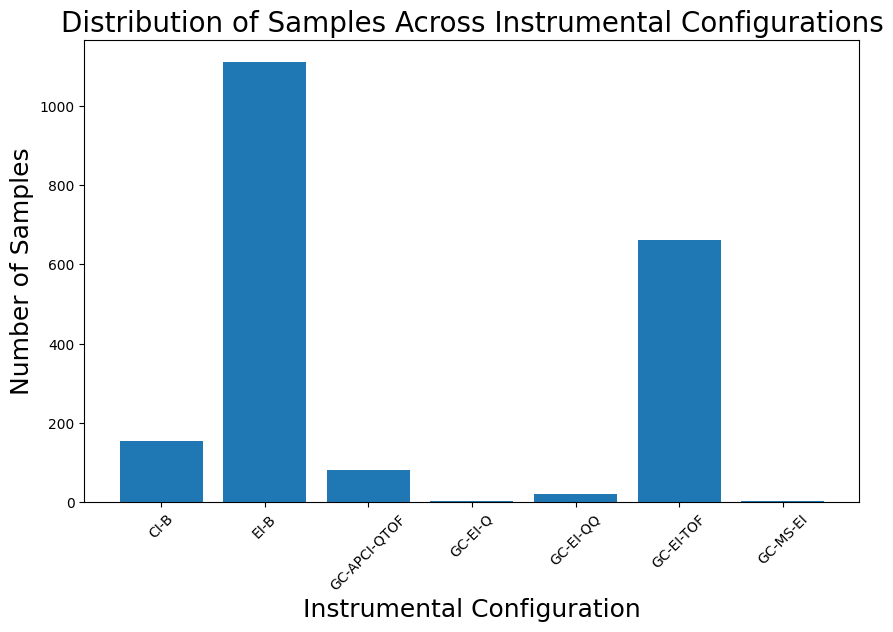

In [46]:
instrument_dict = make_property_count_dict(suppl, 'INSTRUMENT TYPE')

instrumental_configurations, number_of_samples = zip(*sorted(instrument_dict.items()))

plt.figure(figsize=(10, 6))
plt.bar(instrumental_configurations, number_of_samples)

# Add titles and labels
plt.title("Distribution of Samples Across Instrumental Configurations", fontsize=20)
plt.xlabel('Instrumental Configuration', fontsize=18)
plt.xticks(instrumental_configurations, rotation=45)
plt.ylabel('Number of Samples', fontsize=18)
plt.show()

In [47]:
# looking at frequency of each property in the filtered dataset
all_prop_counts = {}

for mol in suppl:
    props = mol.GetPropNames()
    for prop in props:
        if not prop in all_prop_counts.keys():
            all_prop_counts[prop] = 1
        else:
            all_prop_counts[prop] += 1

all_prop_counts

{'NAME': 2032,
 'SYNONYMS': 2032,
 'SPECTRUM TYPE': 2032,
 'INSTRUMENT TYPE': 2032,
 'INSTRUMENT': 2032,
 'ION MODE': 2032,
 'INCHIKEY': 2032,
 'FORMULA': 2032,
 'EXACT MASS': 2032,
 'MW': 2032,
 'ID': 2032,
 'CONTRIBUTOR': 2032,
 'COMMENT': 2032,
 'NUM PEAKS': 2032,
 'MASS SPECTRAL PEAKS': 2032,
 'PRECURSOR M/Z': 81,
 'PRECURSOR TYPE': 80,
 'COLLISION ENERGY': 80}

### Back to InChIKey:
---

It would be interesting to play around with the minimum rating threshold here. Less than 3% of spectra are rated below 3.7/5.0, but only about 16% of spectra are rated above 3.8/5.0. I haven't found any information on how MoNA calculates the scores, but in theory they represent confidence in the sample. 

In [48]:
# # Only looking at mols with a listed inchikey and spectrum type that also have a mona rating above a certain threshold
# save_file_path = '../data/gc_ms_with_inchikey_and_mona_rating.sdf'
# suppl, total_samples, usable_samples, usable_samples_w_inchikey = make_SDMOLSupplier_with_specified_properties(original_suppl, ['INCHIKEY', 'SPECTRUM TYPE'], mona_rating=3.74, file_path=save_file_path)
# print(f'There are {len(suppl):,} samples with the specified properties.')

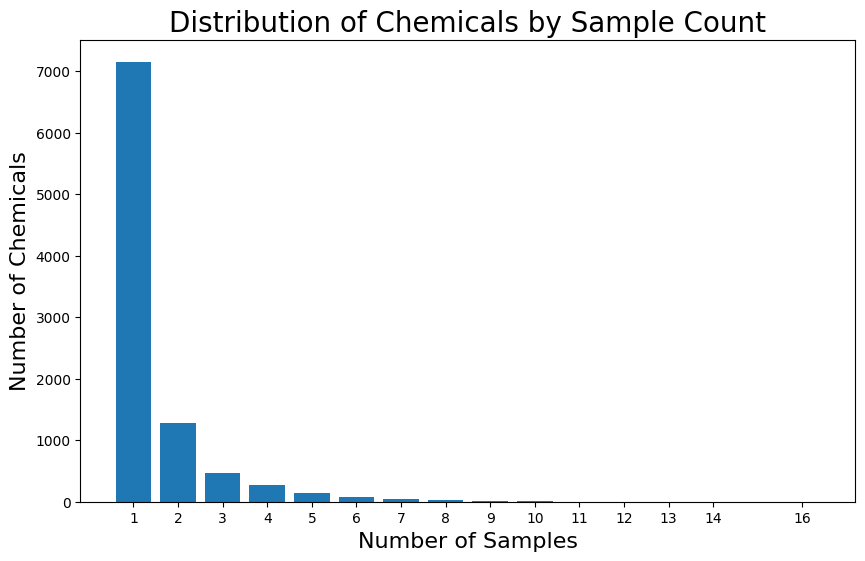

In [49]:
counts = Counter(inchikey_count_dict.values())
number_of_samples, number_of_chemicals = zip(*sorted(counts.items()))

plt.figure(figsize=(10, 6))
plt.bar(number_of_samples, number_of_chemicals)

# Add titles and labels
plt.title("Distribution of Chemicals by Sample Count", fontsize=20)
plt.xlabel('Number of Samples', fontsize=16)
plt.xticks(number_of_samples)
plt.ylabel('Number of Chemicals', fontsize=16)
plt.show()

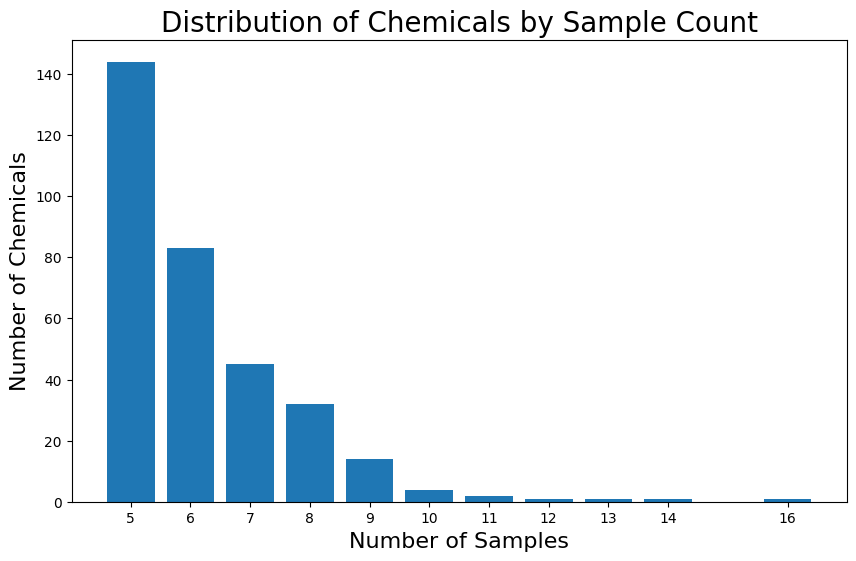

In [50]:
counts = Counter(inchikey_count_dict.values())
number_of_samples, number_of_chemicals = zip(*sorted(counts.items()))

plt.figure(figsize=(10, 6))
plt.bar(number_of_samples[4:], number_of_chemicals[4:])

# Add titles and labels
plt.title("Distribution of Chemicals by Sample Count", fontsize=20)
plt.xlabel('Number of Samples', fontsize=16)
plt.xticks(number_of_samples[4:])
plt.ylabel('Number of Chemicals', fontsize=16)
plt.show()

In [51]:
all_spectra_list = []
inchikeys = []
weights = []
for mol in suppl:
    inchikey = mol.GetProp('INCHIKEY')
    if inchikey in inchikeys_for_chems_past_threshold:
        spec = format_spectrum(mol)
        mw = mol.GetProp('MW')
        all_spectra_list.append(spec)
        inchikeys.append(inchikey)
        weights.append(mw)
        # if len(spec) 
    

- [ ] Look into molecular weight vs highest m/z ratio. Seems like there's something off for a lot of the data...

In [52]:
for i, mol in enumerate(suppl):
    if 4 < i < 10:
        print(mol.GetProp('MW'))
        # print(mol.GetProp('EXACT MASS'))
        print(mol.GetProp('MASS SPECTRAL PEAKS'))
        print(mol.GetProp('COMMENT'))
        print('------------------')
        print('------------------')
        print('------------------')
        print('------------------')

202
60 2.102102
61 0.600601
62 0.100100
65 0.100100
67 0.500501
68 0.300300
69 0.400400
70 7.107107
71 1.501502
72 3.203203
73 100.000000
74 9.809810
75 1.801802
76 0.200200
81 0.200200
82 2.302302
83 1.601602
84 46.746747
85 4.504505
86 34.934935
87 3.803804
88 3.003003
89 0.200200
90 0.200200
92 0.200200
94 0.300300
95 0.200200
96 1.701702
97 0.700701
98 9.409409
99 1.701702
100 18.018018
101 3.003003
102 7.607608
103 1.101101
104 0.400400
105 0.100100
107 0.200200
108 0.300300
109 0.300300
110 2.602603
111 1.701702
112 5.805806
113 1.401401
114 4.004004
115 6.506507
116 37.537538
117 5.305305
118 2.102102
119 0.200200
120 0.200200
122 0.100100
123 0.100100
124 0.300300
125 0.400400
126 0.700701
127 0.400400
128 5.205205
129 5.705706
130 8.408408
131 2.102102
132 1.201201
134 0.100100
135 0.100100
136 0.100100
138 0.100100
139 0.300300
140 1.001001
141 0.600601
142 14.014014
143 4.204204
144 42.442442
145 6.106106
146 5.405405
147 0.300300
148 0.300300
151 0.200200
152 0.200200
154 0

In [53]:
len(suppl)

2032

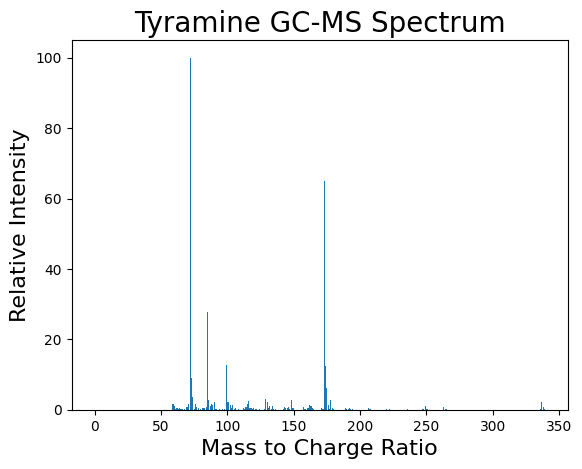

60 1.601602
61 1.001001
62 0.200200
63 0.500501
64 0.100100
65 0.500501
66 0.100100
67 0.300300
69 0.100100
70 0.900901
71 0.700701
72 1.701702
73 100.000000
74 9.109109
75 3.503504
76 0.300300
77 1.501502
78 0.800801
79 0.600601
81 0.100100
82 0.400400
83 0.400400
84 0.400400
85 0.800801
86 27.727728
87 2.802803
88 1.101101
89 1.501502
90 1.201201
91 2.102102
92 0.200200
93 0.200200
95 0.300300
97 0.100100
99 0.300300
100 12.812813
101 2.202202
102 2.202202
103 1.201201
104 0.500501
105 1.201201
106 0.100100
107 0.400400
109 0.200200
113 0.400400
114 0.300300
115 0.800801
116 1.501502
117 2.502503
118 0.500501
119 0.600601
120 0.100100
121 0.600601
122 0.100100
123 0.100100
125 0.100100
129 0.200200
130 3.103103
131 2.202202
132 0.600601
133 1.101101
134 0.300300
135 1.101101
136 0.100100
137 0.100100
143 0.100100
144 0.800801
145 0.600601
146 0.500501
147 0.900901
148 0.300300
149 2.802803
150 0.500501
151 0.500501
158 0.700701
159 0.300300
160 0.300300
161 0.400400
162 0.500501
163 

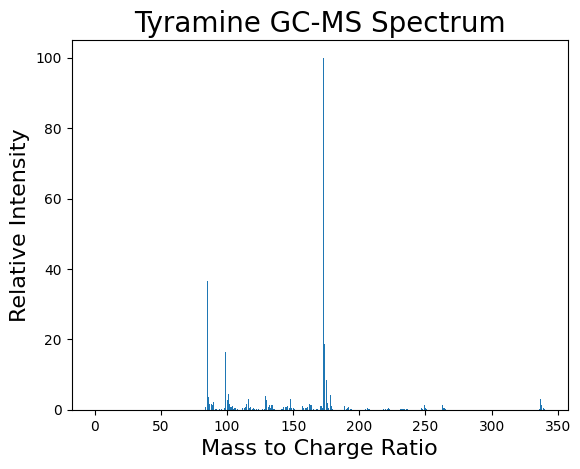

85 0.900901
86 36.636637
87 3.703704
88 1.501502
89 1.601602
90 1.201201
91 2.302302
92 0.200200
93 0.200200
95 0.300300
97 0.100100
99 0.400400
100 16.316316
101 2.702703
102 4.404404
103 1.501502
104 0.700701
105 1.101101
106 0.200200
107 0.500501
109 0.200200
113 0.400400
114 0.400400
115 0.900901
116 1.701702
117 3.003003
118 0.600601
119 0.800801
120 0.100100
121 0.600601
122 0.100100
123 0.200200
125 0.200200
128 0.100100
129 0.300300
130 3.903904
131 2.702703
132 0.800801
133 1.401401
134 0.400400
135 1.301301
136 0.200200
137 0.200200
142 0.100100
143 0.200200
144 0.900901
145 0.700701
146 0.900901
147 1.101101
148 0.500501
149 3.003003
150 0.600601
151 0.600601
152 0.100100
158 1.001001
159 0.400400
160 0.500501
161 0.600601
162 0.700701
163 1.601602
164 1.301301
165 1.201201
166 0.200200
169 0.100100
172 1.001001
173 0.400400
174 100.000000
175 18.718719
176 8.508509
177 1.901902
178 0.400400
179 4.204204
180 1.101101
181 0.300300
190 1.001001
191 0.300300
192 0.400400
193 0.

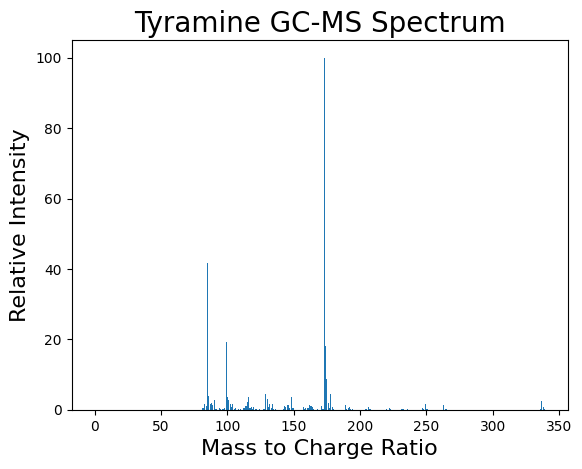

82 0.600601
83 0.400400
84 1.501502
85 1.101101
86 41.741742
87 4.004004
88 1.601602
89 1.901902
90 1.401401
91 2.902903
92 0.300300
93 0.300300
95 0.400400
96 0.100100
97 0.100100
98 0.100100
99 0.500501
100 19.219219
101 3.703704
102 2.902903
103 1.701702
104 0.800801
105 1.601602
106 0.200200
107 0.500501
109 0.300300
111 0.100100
113 0.600601
114 0.500501
115 1.101101
116 2.102102
117 3.503504
118 0.600601
119 0.900901
120 0.100100
121 0.800801
122 0.100100
123 0.200200
125 0.200200
128 0.100100
129 0.300300
130 4.604605
131 3.003003
132 0.800801
133 1.701702
134 0.400400
135 1.501502
136 0.200200
137 0.200200
143 0.200200
144 1.001001
145 0.800801
146 1.301301
147 1.301301
148 0.500501
149 3.503504
150 0.500501
151 0.600601
158 0.900901
159 0.300300
160 0.400400
161 0.500501
162 0.600601
163 1.401401
164 1.001001
165 0.900901
166 0.100100
169 0.100100
172 1.001001
173 0.300300
174 100.000000
175 18.218218
176 8.608609
177 1.901902
178 0.400400
179 4.404404
180 0.800801
181 0.20020

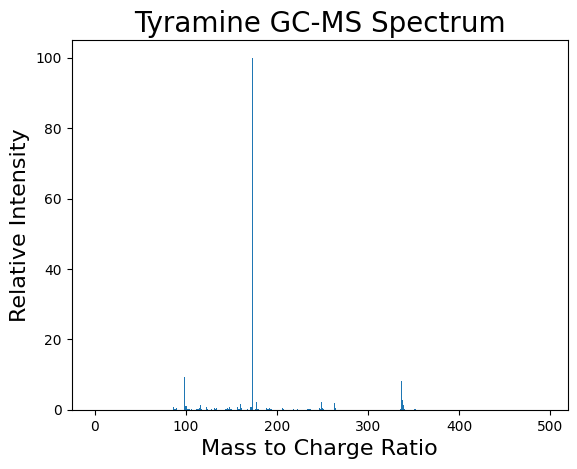

86.050000 18.564447
87.050000 1.733384
88.050000 0.674359
89.050000 0.215146
90.050000 0.189380
91.050000 0.546784
92.000000 0.047648
93.000000 0.038143
94.000000 0.012215
95.050000 0.062453
96.100000 0.019334
97.100000 0.033896
98.100000 0.024310
99.150000 0.159691
100.050000 9.322874
101.050000 1.103923
102.050000 1.032086
103.050000 0.326946
104.100000 0.141449
105.050000 0.269752
106.100000 0.039842
107.100000 0.080493
108.100000 0.017636
109.000000 0.052057
110.000000 0.012580
111.000000 0.024512
112.000000 0.014723
113.050000 0.136474
114.100000 0.131984
115.050000 0.266030
116.050000 0.537804
117.100000 1.286346
118.050000 0.222265
119.100000 0.273999
120.000000 0.037294
121.050000 0.183030
122.000000 0.025847
123.000000 0.030175
123.600000 0.011932
124.600000 0.766299
125.550000 0.127818
126.600000 0.008494
127.600000 0.013833
129.150000 0.114105
130.050000 1.720157
131.050000 1.457080
132.100000 0.393079
133.050000 0.570851
134.100000 0.118919
135.050000 0.393241
136.100000 0.

In [54]:
for i, mol in enumerate(suppl):
    # if i < 5:
    spec = format_spectrum(mol)
    name = mol.GetProp('NAME')
    if name =='Tyramine':
        plot_spectrum(spec, name)
        print(mol.GetProp('MASS SPECTRAL PEAKS'))
    # break

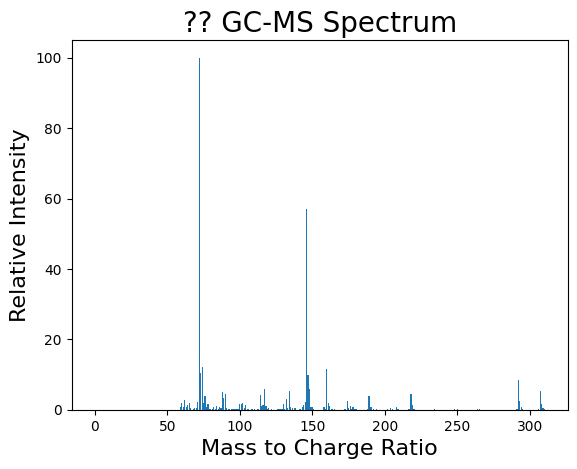

In [55]:
plot_spectrum(all_spectra_list[25], '??')

In [56]:
incorrect = 0

for spec, mw in zip(all_spectra_list, weights):
    if len(spec) > float(mw):
        # print(int(float(mw)))
        print(round(sum(spec[int(float(mw)):])), mw)
        print(len(spec), mw)
        print('-----------------------------')
        # incorrect+=1
# incorrect

111 137
340 137
-----------------------------
236 126
273 126
-----------------------------
171 118
263 118
-----------------------------
21 284
358 284
-----------------------------
6 202
619 202
-----------------------------
18 202
739 202
-----------------------------
107 145
491 145
-----------------------------
69 169
372 169
-----------------------------
127 154
373 154
-----------------------------
167 138
285 138
-----------------------------
88 138
284 138
-----------------------------
123 131
363 131
-----------------------------
107 131
362 131
-----------------------------
181 103
307 103
-----------------------------
21 176
523 176
-----------------------------
20 176
524 176
-----------------------------
20 176
435 176
-----------------------------
36 177
321 177
-----------------------------
95 175
322 175
-----------------------------
44 175
758 175
-----------------------------
338 165
722 165
-----------------------------
217 123
197 123
-----------------------------


In [57]:
# max(list(spec_len_dict.keys()))
# spec_len_dict
# dict(sorted(spec_len_dict.items()))

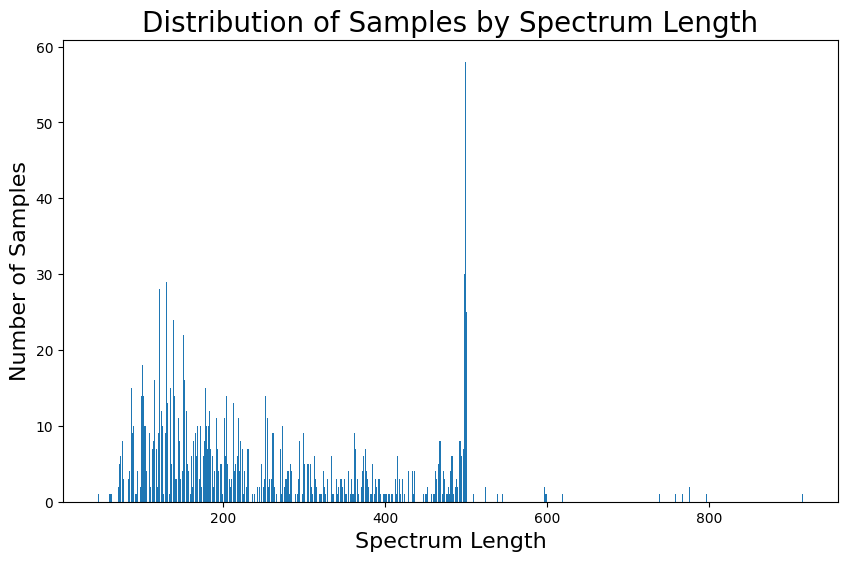

In [58]:
spec_len_dict = {}

for spec in all_spectra_list:
    spec_len = len(spec)
    if spec_len in spec_len_dict.keys():
        spec_len_dict[spec_len] += 1
    else:
        spec_len_dict[spec_len] = 1

# counts = Counter(spec_len_dict.keys())
sample_length, number_of_samples = zip(*sorted(spec_len_dict.items()))


plt.figure(figsize=(10, 6))
plt.bar(sample_length, number_of_samples)

# Add titles and labels
plt.title("Distribution of Samples by Spectrum Length", fontsize=20)
plt.xlabel('Spectrum Length', fontsize=16)
plt.ylabel('Number of Samples', fontsize=16)
plt.show()

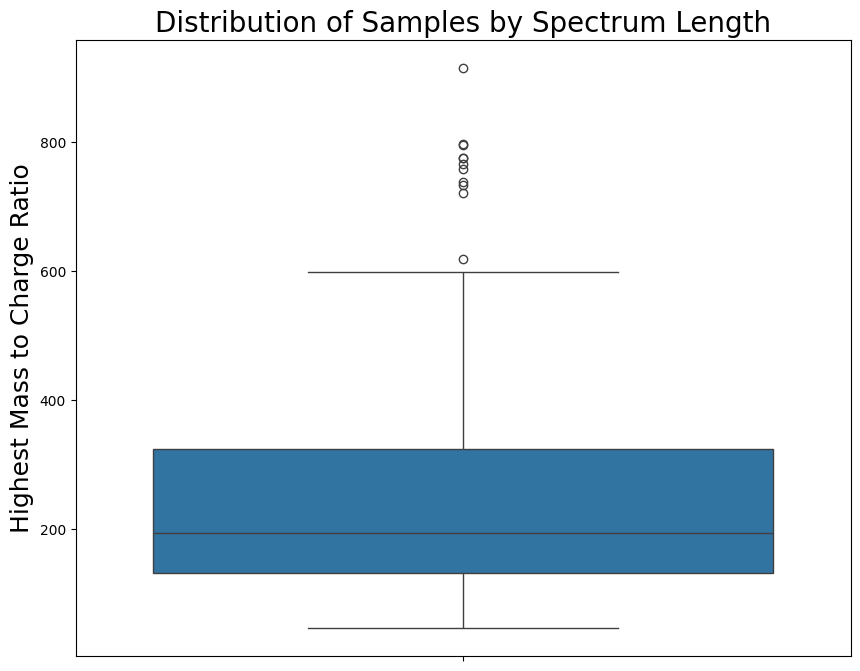

In [59]:
lengths = []
for spec in all_spectra_list:
    lengths.append(len(spec))

plt.figure(figsize=(10, 8))
sns.boxplot(lengths)

plt.ylabel('Highest Mass to Charge Ratio', fontsize=18)
plt.title('Distribution of Samples by Spectrum Length', fontsize=20)

plt.show()

In [60]:
lengths = []
upper_limit = 600
for spec in all_spectra_list:
    if len(spec) < upper_limit:
        lengths.append(len(spec))
print(f'There are {len(lengths):,} spectra with a highest mass to charge ratio under {upper_limit}')

There are 2,021 spectra with a highest mass to charge ratio under 600


In [61]:
long_spectra = []
long_inchikeys = []

upper_limit = 600
for spec, inchikey in zip(all_spectra_list, inchikeys):
    if len(spec) > upper_limit:
        long_spectra.append(spec)
        long_inchikeys.append(inchikey)

print(f'There are {len(long_spectra)} spectra, belonging to {len(set(long_inchikeys))} chemicals, with a highest mass to charge ratio > 600.')

There are 11 spectra, belonging to 9 chemicals, with a highest mass to charge ratio > 600.


In [62]:
short_spectra = []
short_inchikeys = []

upper_limit = 600
for spec, inchikey in zip(all_spectra_list, inchikeys):
    if len(spec) <= upper_limit:
        short_spectra.append(spec)
        short_inchikeys.append(inchikey)
# print(f'There are {len(lengths):,} spectra with a highest mass to charge ratio under {upper_limit}')
print(f'There are {len(short_spectra):,} spectra, belonging to {len(set(short_inchikeys))} chemicals, with a highest mass to charge ratio <= 600.')

There are 2,021 spectra, belonging to 328 chemicals, with a highest mass to charge ratio <= 600.


In [63]:
for spec, inchikey in zip(all_spectra_list, inchikeys):
    if inchikey == 'FYGDTMLNYKFZSV-DZOUCCHMSA-N':
        if len(spec) > 500:
            print(spec[-100:])
        # print(len(spec))

[0, 0.2002, 0, 0, 0, 0, 0, 0, 0, 0.1001, 0.4004, 0.4004, 0, 0, 0.2002, 0, 0, 0, 0, 0.1001, 0, 0, 0, 0.1001, 0, 0, 0, 0, 0, 0, 0, 0.3003, 0.1001, 0, 0, 0.2002, 0, 0.1001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2002, 0.4004, 0.2002, 0, 0, 0, 0, 0.2002, 0, 0, 0, 0, 0, 0, 0, 0, 0.1001, 0.1001, 0, 0, 0.1001, 0, 0, 0, 0, 0, 0.1001, 0, 0.1001, 0, 0, 0.2002, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2002, 0.1001, 0, 0, 0.2002]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1001]


In [64]:
short_inchikey_counts = Counter(short_inchikeys)

for key, value in short_inchikey_counts.items():
    if value < 5:
        print(key, value)

GUBGYTABKSRVRQ-QUYVBRFLSA-N 4
MUBZPKHOEPUJKR-UHFFFAOYSA-N 4


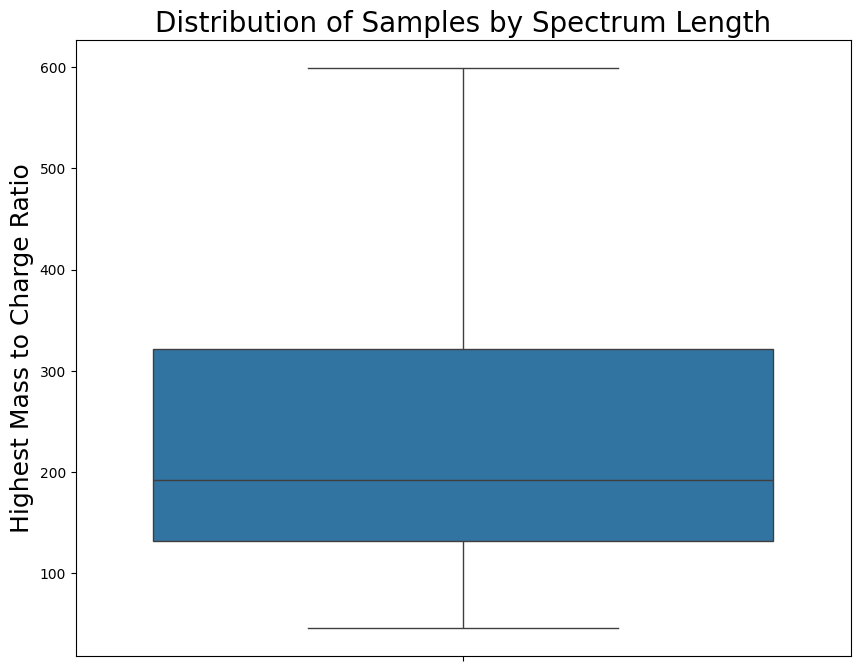

In [65]:
plt.figure(figsize=(10, 8))
sns.boxplot(lengths)

plt.ylabel('Highest Mass to Charge Ratio', fontsize=18)
plt.title('Distribution of Samples by Spectrum Length', fontsize=20)

plt.show()

In [66]:
# all_spectra_df = pd.DataFrame(all_spectra_list)
# all_spectra_df['InCHIKey'] = inchikeys
# all_spectra_df = all_spectra_df.fillna(0)
# all_spectra_df.head()

## Sorting by SMILES:
---

In [76]:
# Only looking at mols with a listed instrument type, spectrum type and inchikey
suppl, total_samples, usable_samples, usable_samples_w_inchikey = make_SDMOLSupplier_with_specified_properties(original_suppl, ['INSTRUMENT TYPE', 'SPECTRUM TYPE', 'INCHIKEY'])
print(f'Of the {total_samples:,} total samples in the database, {round(len(suppl)/total_samples*100, 2)}% have the specified properties.')

prop_count_dict = make_property_count_dict(suppl, 'SMILES')

threshold = 6

total_usable_spectra = 0
num_chems = 0


for chem in prop_count_dict:
    if prop_count_dict[chem] >= threshold:
        total_usable_spectra += prop_count_dict[chem]
        num_chems += 1

print(f'There are {num_chems:,} chemicals, out of the total {len(prop_count_dict):,}, with more than the minimum threshold of {threshold} samples in the database. \nBetween these {num_chems:,} chemicals there are a total of {total_usable_spectra:,} spectra.')

Of the 18,914 total samples in the database, 75.13% have the specified properties.


There are 144 chemicals, out of the total 8,956, with more than the minimum threshold of 6 samples in the database. 
Between these 144 chemicals there are a total of 2,136 spectra.


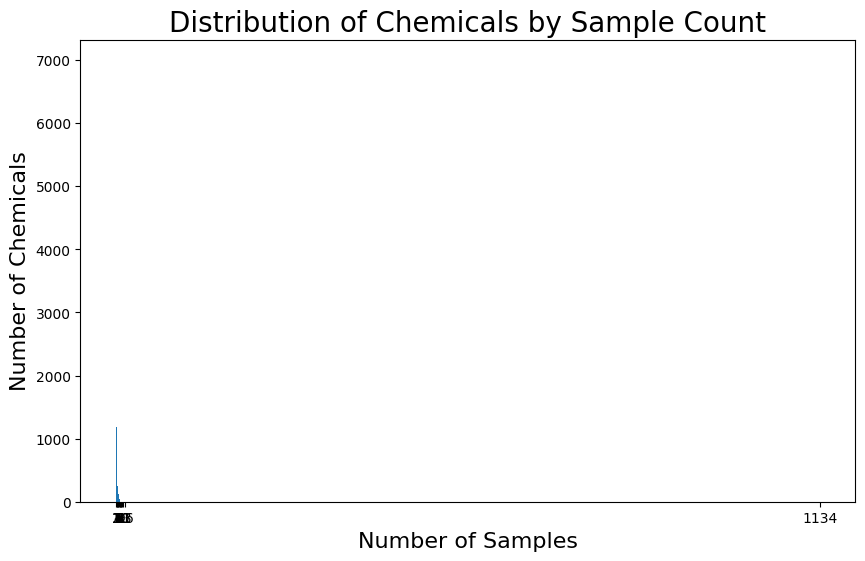

In [68]:
counts = Counter(prop_count_dict.values())
number_of_samples, number_of_chemicals = zip(*sorted(counts.items()))


plt.figure(figsize=(10, 6))
plt.bar(number_of_samples, number_of_chemicals)

# Add titles and labels
plt.title("Distribution of Chemicals by Sample Count", fontsize=20)
plt.xlabel('Number of Samples', fontsize=16)
plt.xticks(number_of_samples)
plt.ylabel('Number of Chemicals', fontsize=16)
plt.show()

Noticing that one SMILES has 1,134 samples, which seems odd. Looking at that further.

In [69]:
for key, value in prop_count_dict.items():
    if value == 1134:
        print(key)

None


Since SMILES isn't a property in the metadata, we can't filter for it. It looks like what's happening is that 1,134 chemicals that do not have SMILES info were included in the dataset.

In [70]:
total_samples_w_smiles = 0
chems_over_threshold = 0
threshold=5

for key, value in prop_count_dict.items():
    if key:
        if value >= threshold:
            chems_over_threshold+=1
            total_samples_w_smiles+=value
print(f'There are {chems_over_threshold:,} chemicals, out of the total {len(prop_count_dict):,}, with more than the minimum threshold of {threshold} samples in the database. \nBetween these {chems_over_threshold:,} chemicals there are a total of {total_samples_w_smiles:,} spectra.')

There are 278 chemicals, out of the total 9,105, with more than the minimum threshold of 5 samples in the database. 
Between these 278 chemicals there are a total of 1,689 spectra.


## Sorting by Name:
---

In [71]:
# Only looking at mols with a listed name, instrument type and spectrum type
suppl, total_samples, usable_samples, usable_samples_w_inchikey = make_SDMOLSupplier_with_specified_properties(original_suppl, ['NAME', 'INSTRUMENT TYPE', 'SPECTRUM TYPE'])
print(f'Of the {total_samples:,} total samples in the database, {round(len(suppl)/total_samples*100, 2)}% have the specified properties.')

prop_count_dict = make_property_count_dict(suppl, 'NAME')

threshold = 5

total_usable_spectra = 0
num_chems = 0


for chem in prop_count_dict:
    if prop_count_dict[chem] >= threshold:
        total_usable_spectra += prop_count_dict[chem]
        num_chems += 1

print(f'There are {num_chems:,} chemicals, out of the total {len(prop_count_dict):,}, with more than the minimum threshold of {threshold} samples in the database. \nBetween these {num_chems:,} chemicals there are a total of {total_usable_spectra:,} spectra.')

Of the 18,914 total samples in the database, 76.25% have the specified properties.


There are 130 chemicals, out of the total 11,366, with more than the minimum threshold of 5 samples in the database. 
Between these 130 chemicals there are a total of 748 spectra.


# More EDA:
---

In [72]:
# Many of the spectra in the database have m/z values as integers rather than floats. Looking at what percentage for the dataset containing specified features. 
all_spectra_list = []
inchikeys = []
total_mols = 0
samples_w_int_m_z_values = 0

for mol in suppl:
    total_mols += 1
    try:
        # some of the samples contain only 0s, filtering those out
        if sum(format_spectrum(mol)) != 0:
            all_spectra_list.append(format_spectrum(mol, m_z_type = 'integer'))
            inchikeys.append(mol.GetProp('INCHIKEY'))
            # samples with float m/z values will throw an error when passed through format_spectrum. 
            # If there is no error we know the sample has int m/z values.
            samples_w_int_m_z_values +=1
    except:
        pass

all_spectra_df = pd.DataFrame(all_spectra_list)
all_spectra_df['InCHIKey'] = inchikeys
all_spectra_df = all_spectra_df.fillna(0)

print(f'Of the {total_mols:,} usable samples, {round(samples_w_int_m_z_values/total_mols*100, 2)}% have integer m/z values.')
# all_spectra_df.head()

Of the 14,422 usable samples, 0.0% have integer m/z values.


In [79]:
# Looking at chemicals whose m/z values are integers when their m/z values from other sources are floats. Tyramine is one such chemical.
i = 0
for chem in suppl:
    if i < 20:
        if chem.GetProp('INCHIKEY') in inchikeys_for_chems_past_threshold:
            i += 1
            print(chem.GetProp('MASS SPECTRAL PEAKS'))
            name = chem.GetProp('NAME')
            print(name)
            print(chem.GetProp('CONTRIBUTOR'))
            print('------------------------')
            print('------------------------')
            print('------------------------')
            # if name == 'Tyramine':
            #     # print(chem.GetProp('MASS SPECTRAL PEAKS'))
            #     spec = format_spectrum(chem)
            #     plot_spectrum(spec, name)
    else:
        break

60 1.601602
61 1.001001
62 0.200200
63 0.500501
64 0.100100
65 0.500501
66 0.100100
67 0.300300
69 0.100100
70 0.900901
71 0.700701
72 1.701702
73 100.000000
74 9.109109
75 3.503504
76 0.300300
77 1.501502
78 0.800801
79 0.600601
81 0.100100
82 0.400400
83 0.400400
84 0.400400
85 0.800801
86 27.727728
87 2.802803
88 1.101101
89 1.501502
90 1.201201
91 2.102102
92 0.200200
93 0.200200
95 0.300300
97 0.100100
99 0.300300
100 12.812813
101 2.202202
102 2.202202
103 1.201201
104 0.500501
105 1.201201
106 0.100100
107 0.400400
109 0.200200
113 0.400400
114 0.300300
115 0.800801
116 1.501502
117 2.502503
118 0.500501
119 0.600601
120 0.100100
121 0.600601
122 0.100100
123 0.100100
125 0.100100
129 0.200200
130 3.103103
131 2.202202
132 0.600601
133 1.101101
134 0.300300
135 1.101101
136 0.100100
137 0.100100
143 0.100100
144 0.800801
145 0.600601
146 0.500501
147 0.900901
148 0.300300
149 2.802803
150 0.500501
151 0.500501
158 0.700701
159 0.300300
160 0.300300
161 0.400400
162 0.500501
163 

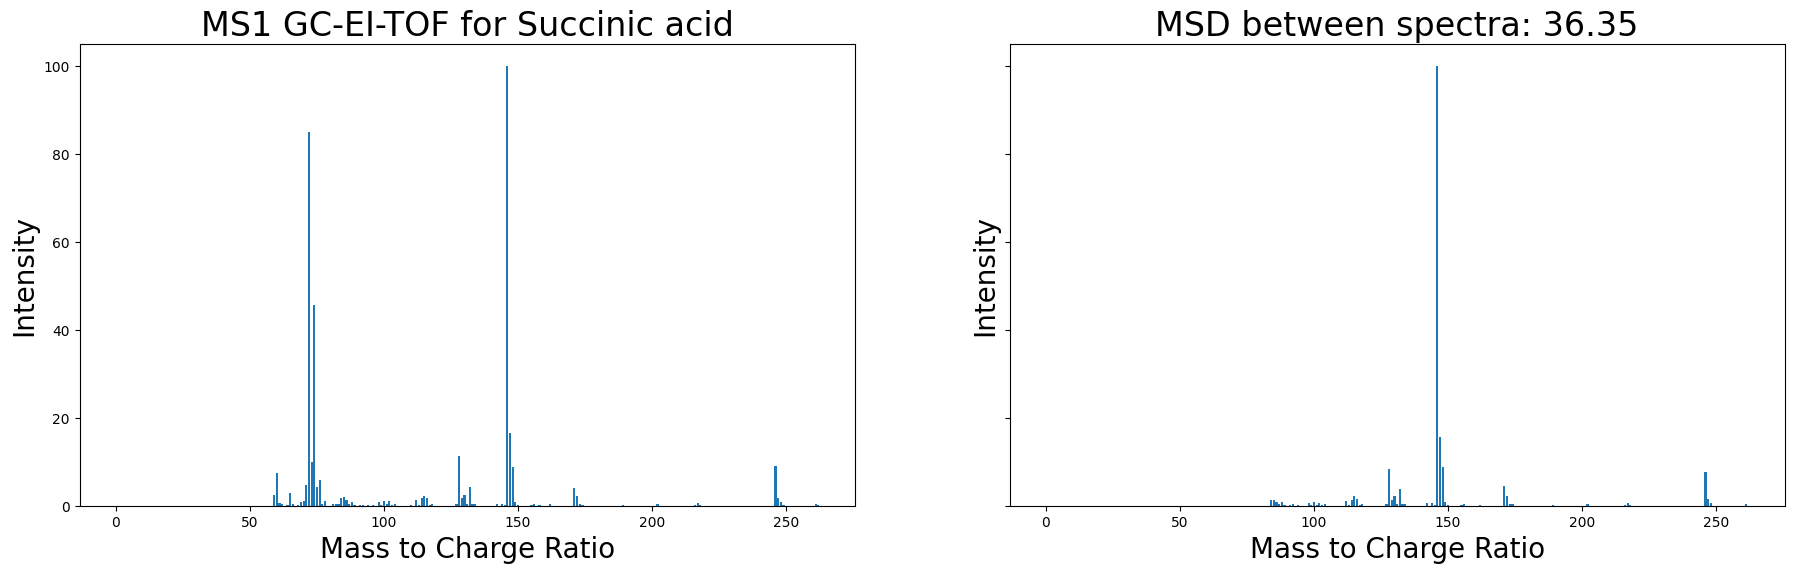

In [95]:
spec1, spec2, prop1, prop2, name = get_comparison_spectra(suppl, 'SPECTRUM TYPE', 'same')#, print_mol=True)
# spec1 and spec2 from above end up being two succinic acid spectra. I checked and they are both 'MS1' GC-EI-TOF spectra
plot_spectra_comparison(name, spec1, spec2, "MS1 GC-EI-TOF")

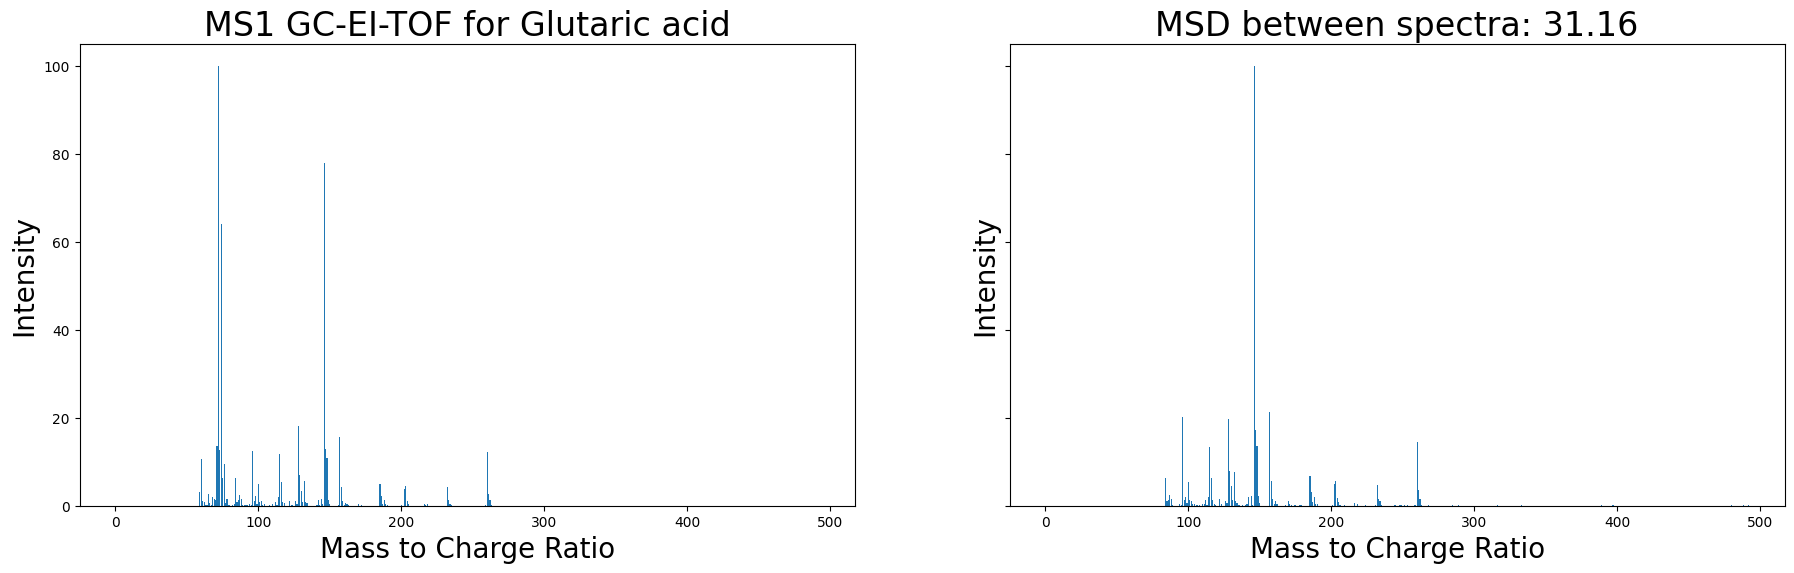

In [101]:
spec1, spec2, prop1, prop2, name = get_comparison_spectra(suppl, 'SPECTRUM TYPE', 'same', start_point=100)#, print_mol=True)
# spec1 and spec2 from above end up being two glutaric acid spectra. I checked and they are both 'MS1' GC-EI-TOF spectra
plot_spectra_comparison(name, spec1, spec2, "MS1 GC-EI-TOF")

In [5]:
# creating a list of all of all the properties we can access in the metadata
all_prop_names = set()
for chem in suppl:
    if chem is not None:
        prop_names = chem.GetPropNames()
        all_prop_names.update(prop_names)

all_prop_names = list(all_prop_names)
all_prop_names

# Looking at the Data:
---

The size of the difference between some of these spectra for the same chemical is confusing. This does not appear to be caused by an error in the code. 

The spectra in the plot below are for the same chemical, in the same lab, using the same type of machinery but they look VERY different. I'm going to dig a little to see if I can figure out what's going on here.

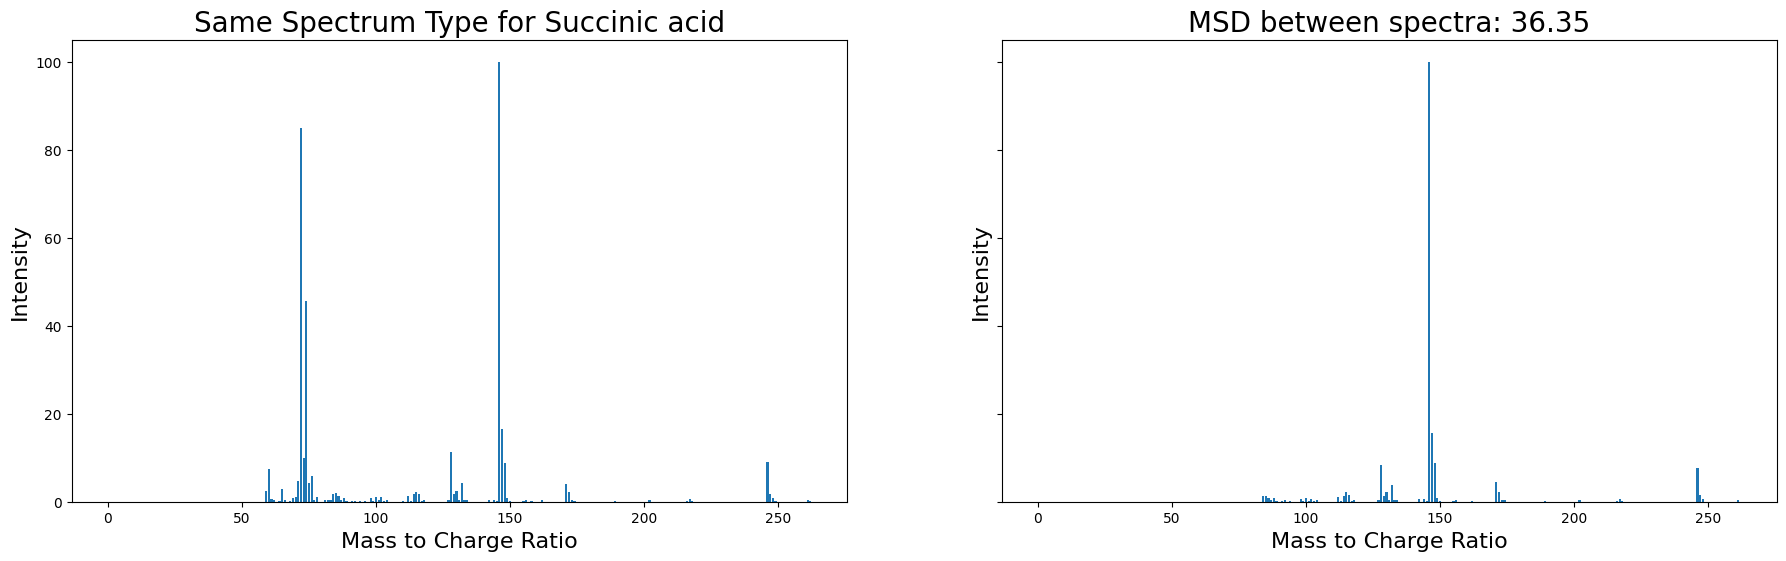

MS1 MS1


In [53]:
file_path = '../data/gc_ms_with_inchikey.sdf'
suppl = Chem.SDMolSupplier(file_path)
spec1, spec2, prop1, prop2, name = get_comparison_spectra(suppl, 'SPECTRUM TYPE', 'same')#, print_mol=True)
plot_spectra_comparison(name, spec1, spec2, 'Same Spectrum Type')
print(prop1, prop2)

In [54]:
all_spectra_list = []
inchikeys = []
for mol in suppl:
    try:
        # some of the samples contain only 0s, filtering those out
        if sum(format_spectrum(mol)) != 0:
            all_spectra_list.append(format_spectrum(mol))
            inchikeys.append(mol.GetProp('INCHIKEY'))
    except:
        pass

all_spectra_df = pd.DataFrame(all_spectra_list)
all_spectra_df['InCHIKey'] = inchikeys
all_spectra_df = all_spectra_df.fillna(0)
all_spectra_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2448,2449,2450,2451,2452,2453,2454,2455,2456,InCHIKey
0,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SJBLBJCIOBWHAC-UHFFFAOYSA-N
1,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KPJQHWSCXRGXAB-UHFFFAOYSA-N
2,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KPJQHWSCXRGXAB-UHFFFAOYSA-N
3,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PHHRZFRBFLDDTQ-UHFFFAOYSA-N
4,0.0,0.0,0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,REWAKYJADCBFMU-UFSSTKFDSA-N


In [55]:
# Count the frequency of each chemical
inchikey_counts = all_spectra_df['InCHIKey'].value_counts()

# Drop rows for chemicals that only appears once or twice
chems_above_threshold = all_spectra_df[all_spectra_df['InCHIKey'].isin(inchikey_counts[inchikey_counts > 2].index)]

# Drop rows that have only 0s 
chems_above_threshold = chems_above_threshold.loc[(chems_above_threshold.iloc[:, :-1]!=0).any(axis=1)]

In [56]:
average_sims = {}
sims = {}
# Calculate pairwise similarity between all spectra for each chemical
for inchikey in list(set(chems_above_threshold['InCHIKey'])):
    chem_similarities = []
    chem_subset = chems_above_threshold.loc[chems_above_threshold['InCHIKey'] == inchikey]
    chem_subset = chem_subset.drop('InCHIKey', axis=1).T
    highest_nonzero = [np.where(chem_subset[i])[0].max() for i in chem_subset.columns]
    highest_nonzero = max(highest_nonzero)
    for i, j in combinations(chem_subset.columns, 2):
        similarity = MSE(chem_subset[i][:highest_nonzero], chem_subset[j][:highest_nonzero])
        chem_similarities.append(round(similarity, 2))
    
    sims[inchikey] = chem_similarities
    avg_sim = np.mean(chem_similarities)
    # print(avg_sim)
    average_sims[inchikey] = avg_sim

In [57]:
# A couple chemicals have NaNs, something to look into later but removing for now
nans = [key for key, value in average_sims.items() if np.isnan(value)]
for key in nans:
    del average_sims[key]
any(np.isnan(value) for value in average_sims.values())

False

In [58]:
diffs = list(average_sims.values())

# Calculate summary statistics to understand a little better the variation of spectra across the dataset
mean_val = statistics.mean(diffs)
median_val = statistics.median(diffs)
stdev_val = statistics.stdev(diffs)
variance_val = statistics.variance(diffs)

print('Minimum: ', min(diffs))
print(f'Maximum: {max(diffs):.2f}')
print(f"Mean: {mean_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Standard Deviation: {stdev_val:.2f}")
print(f"Variance: {variance_val:.2f}")

Minimum:  0.10000000000000002
Maximum: 342.83
Mean: 56.83
Median: 43.08
Standard Deviation: 50.99
Variance: 2599.49


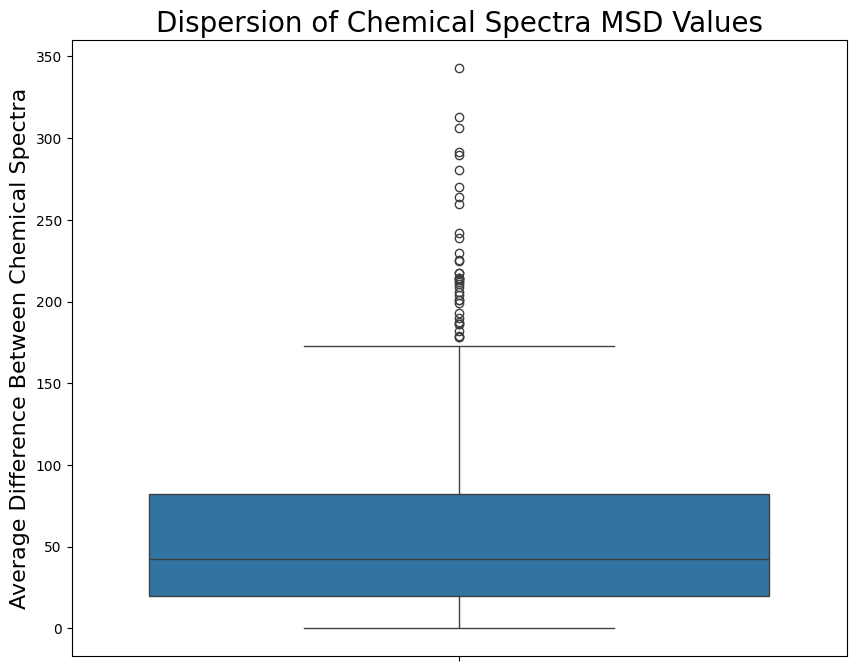

In [34]:
plt.figure(figsize=(10, 8))
sns.boxplot(diffs)

plt.ylabel('Average Difference Between Chemical Spectra', fontsize=16)
plt.title('Dispersion of Chemical Spectra MSD Values', fontsize=20)

plt.show()

Would be interesting to see this broken down by chemical (for at least the most common chemicals). There are too many chemicals in the dataset to display on one plot so I'll limit to the most common spectra.

In [60]:
spectra_sims_list = list(sims.items())

# Sort the list by length of value lists in descending order
spectra_sims_list.sort(key=lambda x: len(x[1]), reverse=True)

# Extract the most common chemical names
most_common_chems = [key for key, _ in spectra_sims_list[:20]]

# Create a new dictionary with the top chemicals
most_common_chems = {key: sims[key] for key in most_common_chems}

/tmp/ipykernel_445740/4290521458.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(most_common_chems.keys()), rotation=90)


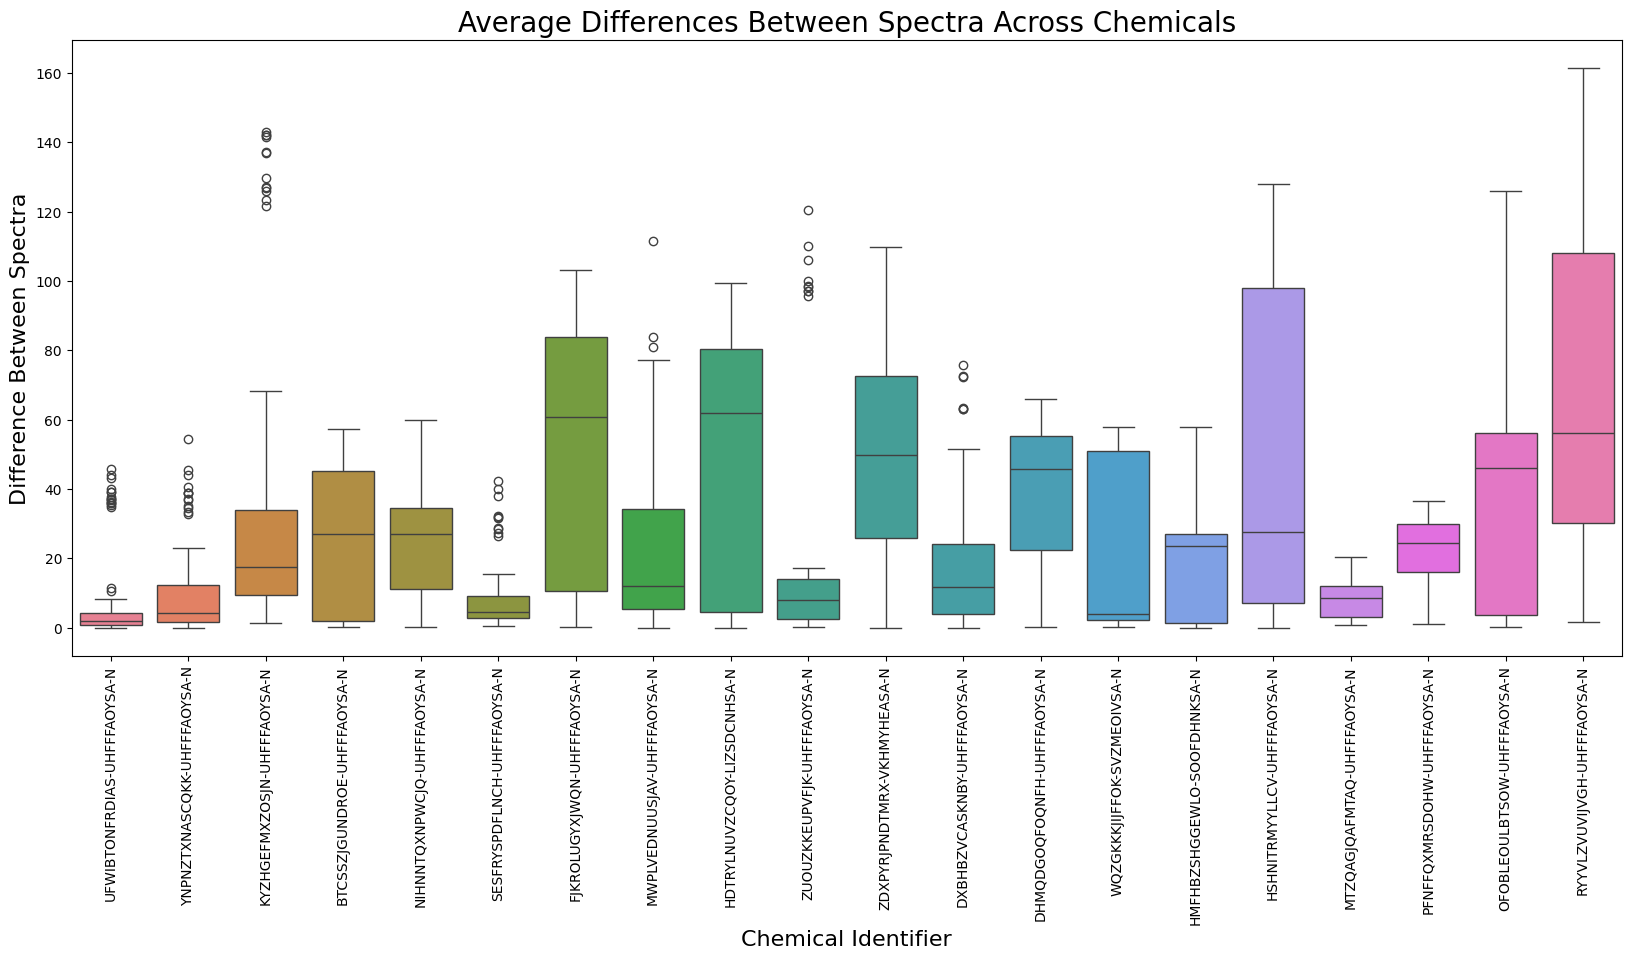

In [61]:
fig, ax = plt.subplots(figsize=(20, 8))

# Create the boxplot
sns.boxplot(data=list(most_common_chems.values()), ax=ax)

ax.set_xticklabels(list(most_common_chems.keys()), rotation=90)

plt.ylabel('Difference Between Spectra', fontsize=16)
plt.xlabel('Chemical Identifier', fontsize=16)
plt.title('Average Differences Between Spectra Across Chemicals', fontsize=20)

plt.show()

/tmp/ipykernel_154325/4290521458.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(most_common_chems.keys()), rotation=90)


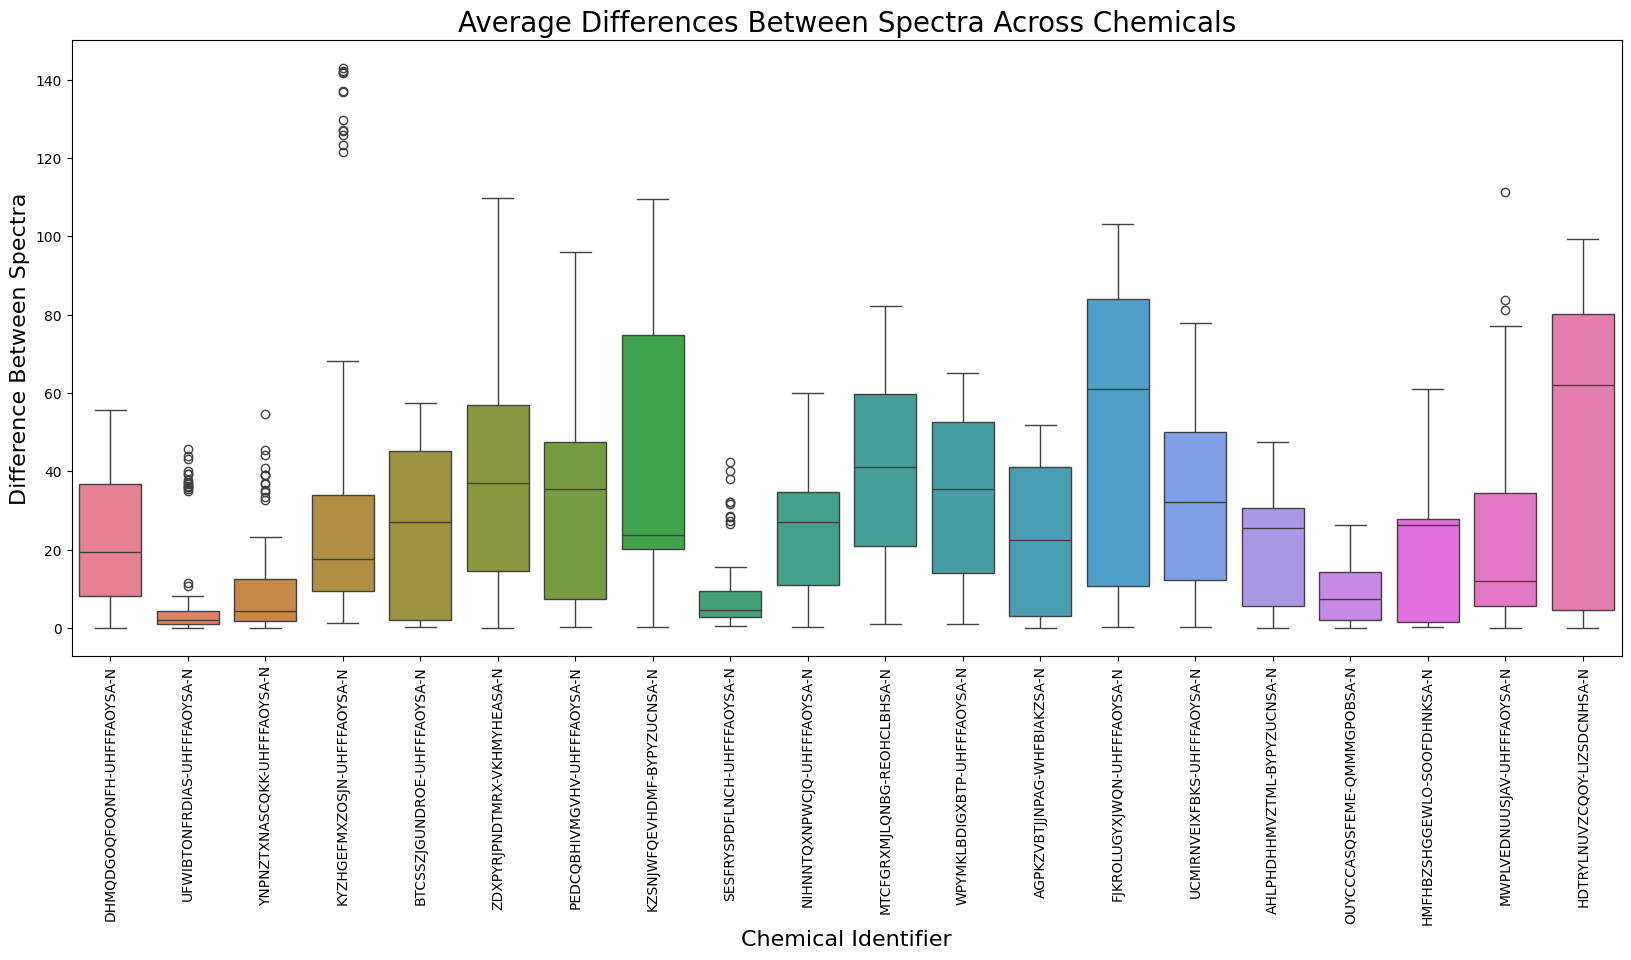

In [36]:
fig, ax = plt.subplots(figsize=(20, 8))

# Create the boxplot
sns.boxplot(data=list(most_common_chems.values()), ax=ax)

ax.set_xticklabels(list(most_common_chems.keys()), rotation=90)

plt.ylabel('Difference Between Spectra', fontsize=16)
plt.xlabel('Chemical Identifier', fontsize=16)
plt.title('Average Differences Between Spectra Across Chemicals', fontsize=20)

plt.show()

# So far only looked at MSE. Should really do this with weighted cosine and compare

# Comparison with other MoNA dataset of all experimental spectra:
---
MoNA has a much larger dataset of experimental spectra (~12 times larger than the dataset used above). When I looked into this dataset I found that the variation between spectra was significantly larger, even for samples prepared under the same experimental conditions. I don't know why that discrepancy exists, but I'd like to get opinions from the chemistry side.

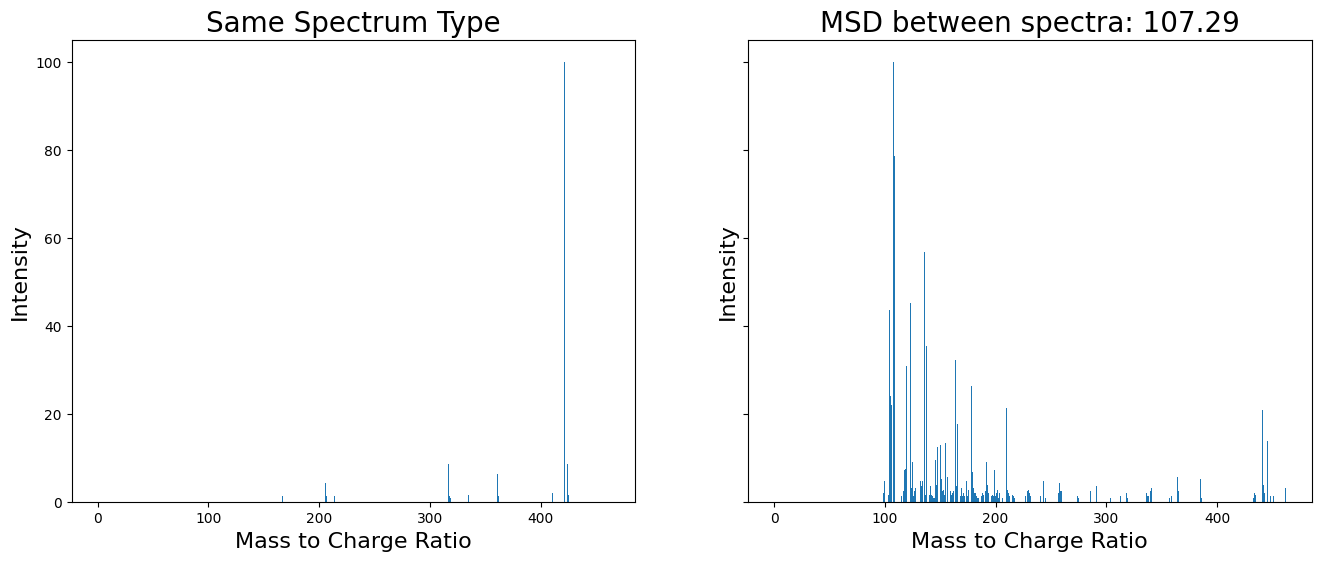

In [61]:
file_path = '/home/cmdunham/ChemicalDataGeneration/data/ms1_ms2_with_inchikey.sdf'
suppl = Chem.SDMolSupplier(file_path)
spec1, spec2, prop1, prop2 = get_comparison_spectra(suppl, 'SPECTRUM TYPE', 'same', 3)
plot_spectra_comparison(spec1, spec2, 'Same Spectrum Type')

In [62]:
all_spectra_list = []
inchikeys = []
for mol in suppl:
    try:
        # some of the samples contain only 0s, filtering those out
        if sum(format_spectrum(mol)) != 0:
            all_spectra_list.append(format_spectrum(mol))
            inchikeys.append(mol.GetProp('INCHIKEY'))
    except:
        pass

all_spectra_df = pd.DataFrame(all_spectra_list)
all_spectra_df['InCHIKey'] = inchikeys
all_spectra_df = all_spectra_df.fillna(0)
all_spectra_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7700,7701,7702,7703,7704,7705,7706,7707,7708,InCHIKey
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JFPVXVDWJQMJEE-IZRZKJBUSA-N


In [63]:
# Count the frequency of each chemical
inchikey_counts = all_spectra_df['InCHIKey'].value_counts()

# Drop rows for chemicals that only appears once or twice
chems_above_threshold = all_spectra_df[all_spectra_df['InCHIKey'].isin(inchikey_counts[inchikey_counts > 2].index)]

# Drop rows that have only 0s 
chems_above_threshold = chems_above_threshold.loc[(chems_above_threshold.iloc[:, :-1]!=0).any(axis=1)]

In [64]:
average_sims = {}
sims = {}
# Calculate pairwise similarity between all spectra for each chemical
for inchikey in list(set(chems_above_threshold['InCHIKey'])):
    chem_similarities = []
    chem_subset = chems_above_threshold.loc[chems_above_threshold['InCHIKey'] == inchikey]
    chem_subset = chem_subset.drop('InCHIKey', axis=1).T
    highest_nonzero = [np.where(chem_subset[i])[0].max() for i in chem_subset.columns]
    highest_nonzero = max(highest_nonzero)
    for i, j in combinations(chem_subset.columns, 2):
        similarity = MSE(chem_subset[i][:highest_nonzero], chem_subset[j][:highest_nonzero])
        chem_similarities.append(round(similarity, 2))
    
    sims[inchikey] = chem_similarities
    avg_sim = np.mean(chem_similarities)
    # print(avg_sim)
    average_sims[inchikey] = avg_sim

In [65]:
# A couple chemicals have NaNs, something to look into later but removing for now
nans = [key for key, value in average_sims.items() if np.isnan(value)]
for key in nans:
    del average_sims[key]
any(np.isnan(value) for value in average_sims.values())

False

In [66]:
diffs = list(average_sims.values())

# Calculate summary statistics to understand a little better the variation of spectra across the dataset
mean_val = statistics.mean(diffs)
median_val = statistics.median(diffs)
stdev_val = statistics.stdev(diffs)
variance_val = statistics.variance(diffs)

print('Minimum: ', min(diffs))
print(f'Maximum: {max(diffs):.2f}')
print(f"Mean: {mean_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Standard Deviation: {stdev_val:.2f}")
print(f"Variance: {variance_val:.2f}")

Minimum:  0.0
Maximum: 1370.52
Mean: 58.07
Median: 44.35
Standard Deviation: 69.23
Variance: 4793.21


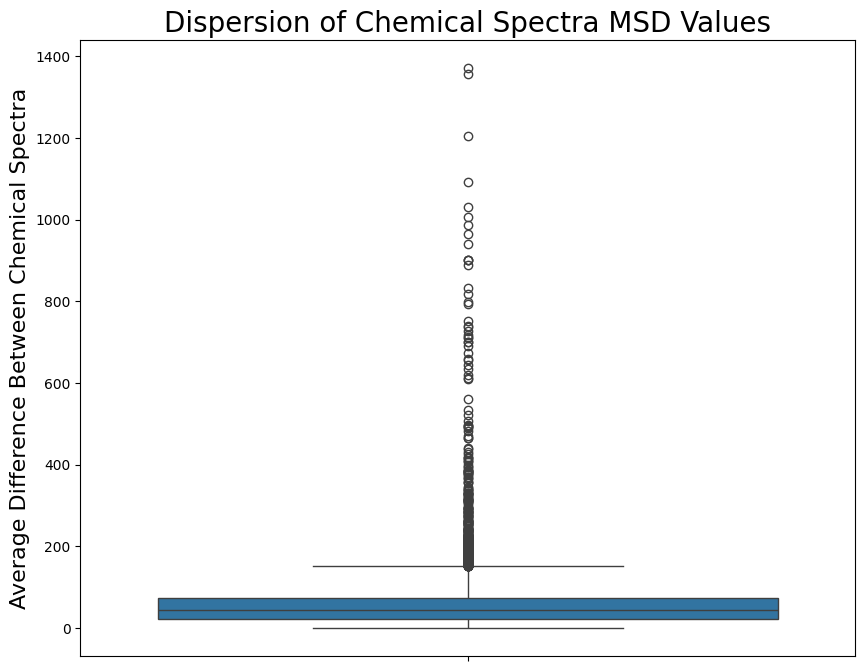

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(diffs)

plt.ylabel('Average Difference Between Chemical Spectra', fontsize=16)
plt.title('Dispersion of Chemical Spectra MSD Values', fontsize=20)

plt.show()

In [68]:
spectra_sims_list = list(sims.items())

# Sort the list by length of value lists in descending order
spectra_sims_list.sort(key=lambda x: len(x[1]), reverse=True)

# Extract the most common chemical names
most_common_chems = [key for key, _ in spectra_sims_list[:20]]

# Create a new dictionary with the top chemicals
most_common_chems = {key: sims[key] for key in most_common_chems}

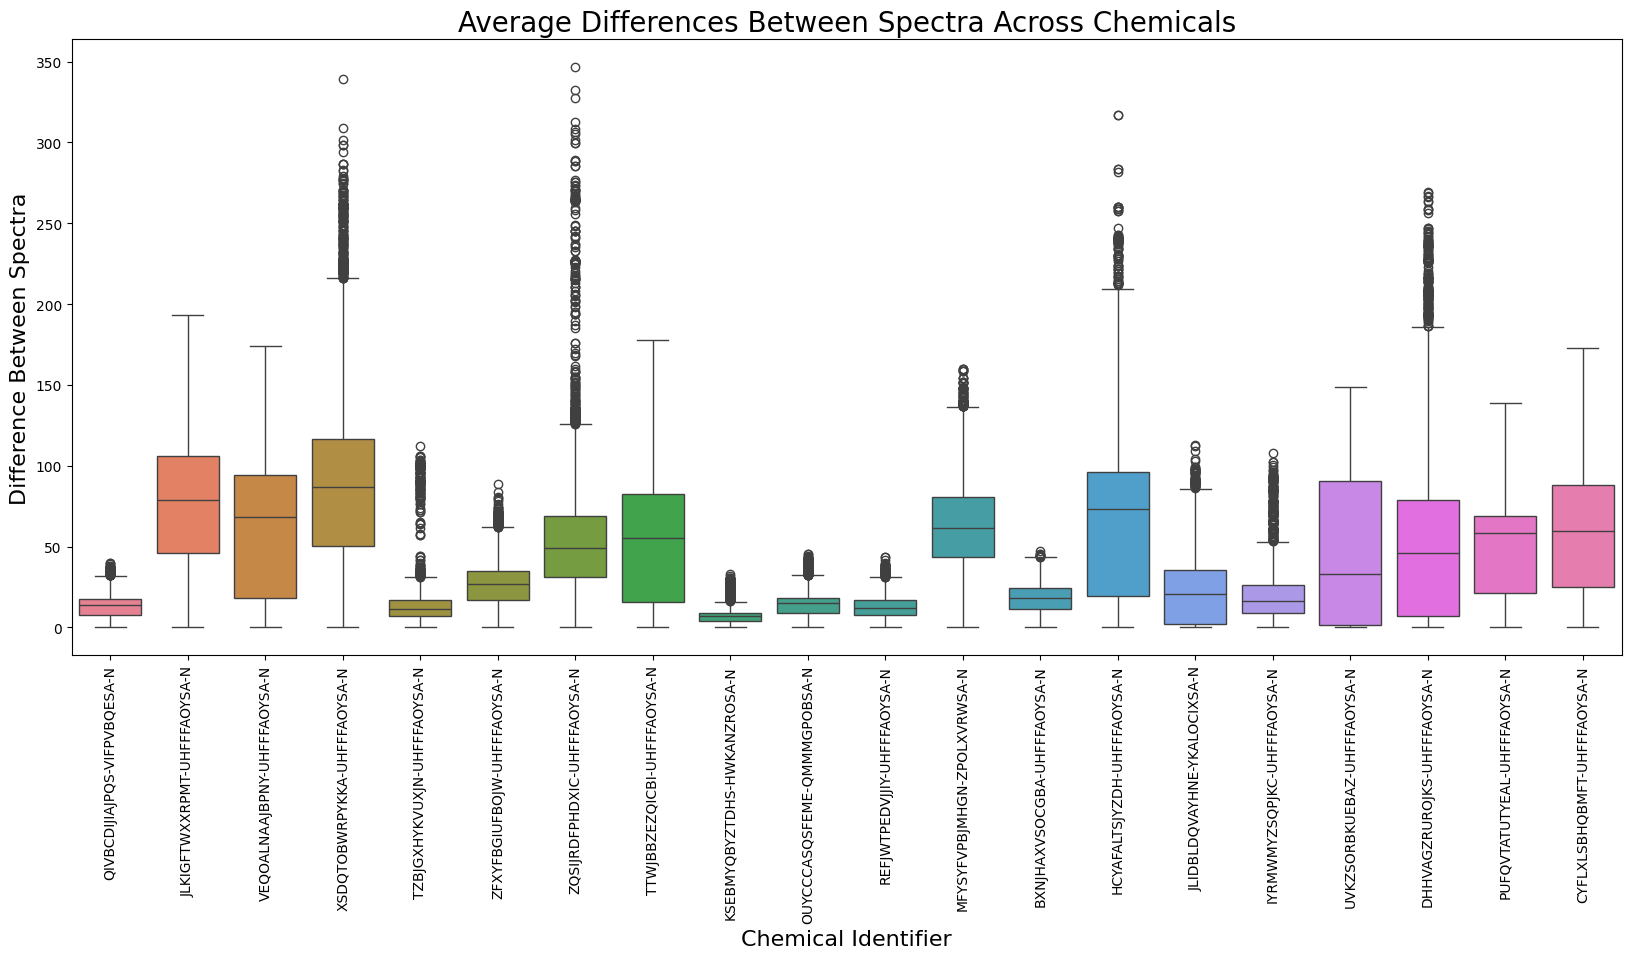

In [69]:
fig, ax = plt.subplots(figsize=(20, 8))

# Create the boxplot
sns.boxplot(data=list(most_common_chems.values()), ax=ax)

plt.xticks(range(len(list(most_common_chems.keys()))), list(most_common_chems.keys()), rotation=90)

plt.ylabel('Difference Between Spectra', fontsize=16)
plt.xlabel('Chemical Identifier', fontsize=16)
plt.title('Average Differences Between Spectra Across Chemicals', fontsize=20)

plt.show()

Looking at this plot we can see that the maximum variation among spectra for the most common chemicals is smaller than for the rest of the dataset (max of ~350 here vs. 1000+ in the full dataset). In both cases it looks like if we set an upper MSE limit of 200 we could still maintain the majority of the data. If we compare to the GC-MS dataset, however, the variation seen here is much higher. 

# SMILES:
---

Chemception needs SMILES strings to generate embeddings. It is possible to represent a chemical using multiple SMILES, but Chemception generates the same embedding for different SMILES pertaining to the same chemical (determined through testing). As such, I will simply select the recorded SMILES corresponding to the first occurance of each chemical in the database.

Since SMILES is not one of the properties we can access directly through the metadata (shown in the Dataset Overview section), we need to determine SMILES by pulling them out of each sample's comment. 

In [12]:
inchikeys_to_use = inchikeys_for_chems_past_threshold.copy()

smiles_dict = {}

for mol in suppl:
  if mol is not None:
    inchikey = mol.GetProp('INCHIKEY')
    if not inchikey in smiles_dict.keys():
      comment = mol.GetProp('COMMENT').split('\n')
      smiles = None
      for line in comment:
        if line.split('=')[0] == 'SMILES':
          smiles = line.split('SMILES=')[1]

      if smiles:
        smiles_dict[inchikey] = smiles

Create df with SMILES and corresponding InCHIKey identifiers and save as .csv file.

In [15]:
inchikey_smiles_df = pd.DataFrame.from_dict(smiles_dict, orient='index', columns=['SMILES'])
inchikey_smiles_df['InCHIKey'] = inchikey_smiles_df.index

save_file = '/home/cmdunham/ChemicalDataGeneration/data/inchikey_smiles.csv'
with open(save_file, 'w') as f:
  inchikey_smiles_df.to_csv(f, index=False)

# Instrument:
---

In the past we have used the instrument a spectrum was generated on as a condition. We may choose to do this again so it is useful to see more details here.

In [62]:
# making a suppl with only spectra with a listed intrument type in their metadata
instrument_suppl = make_SDMOLSupplier_with_specified_properties(suppl, ['INSTRUMENT TYPE'])
instrument_count_dict = make_property_count_dict(instrument_suppl, 'INSTRUMENT TYPE')

In [55]:
samples_w_inchikey_and_instrument = 0
for val in instrument_count_dict:
    samples_w_inchikey_and_instrument+=instrument_count_dict[val]

print(f'Of the total {usable_samples_w_inchikey:,} usable samples in the database with InCHIKey identifiers, {samples_w_inchikey_and_instrument:,}, or {round((samples_w_inchikey_and_instrument/usable_samples_w_inchikey)*100)}%, list the instrument used in sample generation.')

Of the total 139,929 usable samples in the database with InCHIKey identifiers, 122,721, or 88%, list the instrument used in sample generation.


From the plot below we can see that many more spectra were generated using the LC-ESI-QTOF instrument than any other instrument and that 4 or so instruments were used to generate the majority of the spectra in the dataset. It may be prudent to **combine some of the instruments** that were used for relatively few spectra into a single "Other Instrument" category. We can also see that some of the instruments are broken up into different categories due to naming (GC-EI-TOF for example). We will need to **decide how to handle those categories**.

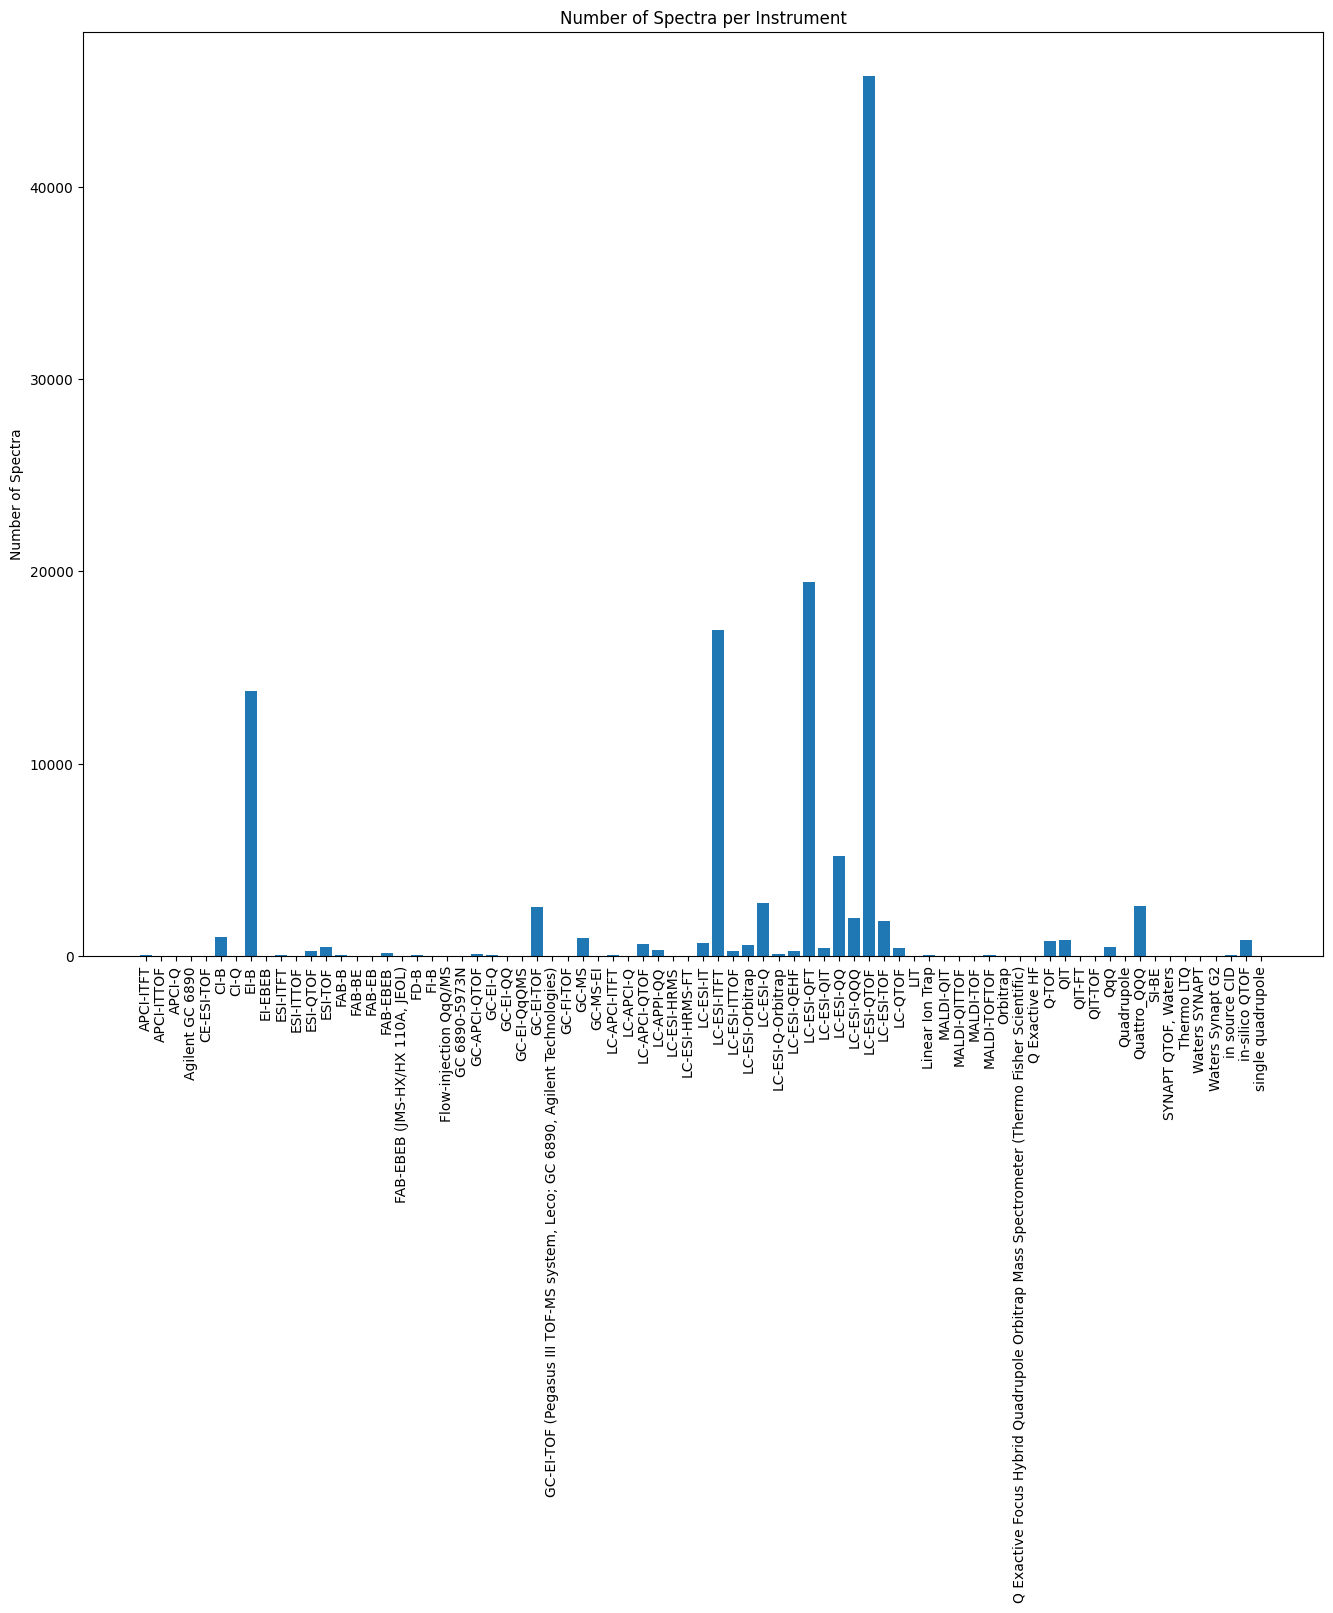

In [21]:
instruments = sorted(list(instrument_count_dict.keys()))
spectra_counts = [instrument_count_dict[instrument] for instrument in instruments]
plt.figure(figsize=(16,12))
plt.bar(instruments, spectra_counts)
plt.title('Number of Spectra per Instrument')
plt.ylabel('Number of Spectra')
plt.xticks(rotation = 90)
plt.show()